## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pickle
import simpy
import time
import pulp
import pandas as pd
import scipy.stats as stats
import os

In [2]:
seed=8268

## Initializing data generation utilities

In [3]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [4]:
def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP         

In [5]:
def generateRandomGraph(n, x0, y0, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    x0 = rounding(x0)
    y0 = rounding(y0)
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [6]:
def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ] 
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E       

In [7]:
def generateGraph(n, x0, y0, r):
    P, E = generateRandomGraph(n, x0, y0, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

In [8]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [9]:
def generateRandomTargets(V, E, n=5):
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 300
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [10]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

In [11]:
def plotMapOld(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

In [12]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False, size=6):
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    resolution = 10000
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if grid:
        plt.grid()
        if text is not None:
            plt.title(text)
    else:
        if text is not None:
            plt.text(0.8*resolution, 0, text)

    plt.show()

In [13]:
#main utility to generate data

In [14]:
#for generating data -imp

def generateData(seed=None, nodes=100, customers=150, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        # print("  W ∈ V  is the location of the distribution warehouse")
        # print("    given as a pair (x, y) of integer coordinates")
        # print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    V, E = generateGraph(nodes, 4000, 4000, 4000)
    
    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)
    
    return (V, E), C


## Initializing Plotting Utilities

In [15]:
def barPlot(count, title=''):
    fig = plt.figure()
    fig.set_figwidth(3 if len(count)<=10 else 5)
    fig.set_figheight(2)
    ax = fig.gca()
    xpos = np.arange(0, len(count))
    labels = [ c for c in range(0, len(count)) ]
    ax.set_xticks(xpos, labels)
    plt.title(title)
    plt.bar(range(0, len(count)), count)

In [16]:
def histplot(data, title="", xlabel="",
             width=None, height=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()
        
    bins=(maxx-minx)//5+1
    hist=plt.hist(data, density=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
        
    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy, 
            f'μ={μ:2.2f}\nσ={σ:2.2f}', 
            ha='right', va='top', 
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [17]:
def dailyPlot(data, 
              title="", ylabel="",
              width=None, height=None):
    
    days = len(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)
    
    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    
    ms = 2 if len(data)>100 else 5
    lw = 0.5 if len(data)>100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)
    
    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')
    
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Step 1 : Generate test data

Generated map with 100 nodes and 150 customer locations


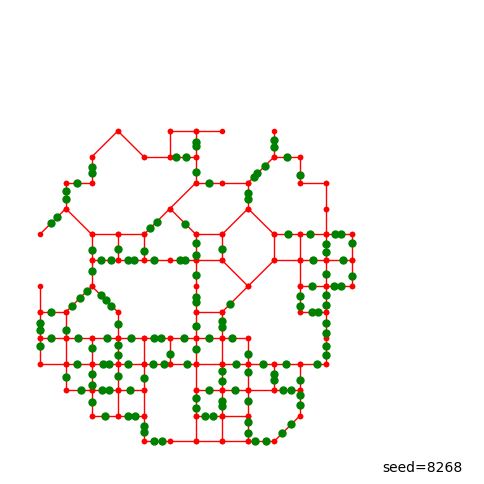

In [18]:
data = generateData(seed, plot=True, log=True)

In [19]:
#save test data for customer locations
with open('customer_data.pickled', 'wb') as f:
    pickle.dump(data, f)

### 1.1 Generate Delivery Data function

In [20]:
## generating delivery data according to specification in assignment

def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=len(C)*p, size=days)
    D = [ sorted(list(np.random.choice(range(len(C)), size=i))) for i in R ]
    return D

### 1.2 Generate Warehouse Location

In [21]:
#for generating a single random warehouse location from Map()
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]#1 sample
    return W

#for generating a multiple random warehouse location from Map()
def generateWarehouseLocations(M, p, seed):

    def numberOfEdges(v, E):
        count = 0
        for e in E:
            if e[0]==v or e[1]==v:
                count += 1
        return count

    V, E = M
    W = [ v for v in V if numberOfEdges(v, E)>2 ]
    random.seed(seed)
    return random.sample(W, k=int(round(len(W)*p)))

## Step 2 : Trip and Path Utilities

### 2.1 Path

In [22]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [23]:
# A* algorithm for shortest path
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

The following is a modified 
[Floyd-Warshall Algorithm](https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm)
calculating in parallel the distances and the shortest path between vertices in a graph M.

In [24]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

### 2.2 Shortest delivery route utilities

In [25]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]
    
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [26]:
def createTables(M, T):
    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

#### Create Roundtrip using iterative integer programming

In [27]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [28]:
def createLoopAStar(M, T):
    D, P = createTables(M, T)
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

In [29]:
def createLoopFW(M, D, P, T):
    V, E = M
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[V.index(T[i])][V.index(T[j])]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[V.index(T[trip[k]])][V.index(T[trip[k+1]])]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

#### Create Roundtrip using Heuristic

In [30]:
def createLoopH(M, D, P, T, plot=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop
    
    V, E = M
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W, 
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
    return makeLoop(L)

## Step 3 : Time Handling Utilities

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [31]:
def timestamp(t):
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t - secs)*10))
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [32]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [33]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [34]:
def day(now):
    return int(now//(24*3600))

## Step 4: Simulation Data Capturing Utilities

We will use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder.

### 4.1 Class Recorder

In [35]:
def cost(daily):#returns cost in euro
    return ((daily.time/3600)*30+0.08*(daily.dist/1000))

class Recorder:
    
    def __init__(self, env, M, W, C, days, parcels,
                 log=False, plot=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.parcels = parcels
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
                
        # create a data frame for time records per working day
        self.daily = pd.DataFrame()
        self.daily['begin'] = [None]*days
        self.daily['end'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days
        
        # create a data frame for records per parcel
        self.precs = pd.DataFrame()
        self.precs['arrived'] = [None]*parcels
        self.precs['delivered'] = [None]*parcels

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end'] = int(round(self.env.now))

    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def recordParcelArrival(self, parcel):
        self.trace(f"{str(parcel):s} arrived in delivery centre")
        self.precs.at[parcel.i, 'arrived'] = day(self.env.now)
        
    def recordParcelDelivery(self, parcel):
        self.trace(f"{str(parcel):s} delivered to customer")
        self.precs.at[parcel.i, 'delivered'] = day(self.env.now)
    ## new fxn    
    def calculateCost(self):
        self.daily['cost']=cost(self.daily)
    
    def finish(self):
        self.daily['time'] = self.daily['end']-self.daily['begin']
        # if at the end of the simulation there are parcels 
        # not yet delivered, register them for the next day
        for i in range(self.parcels):
            if self.precs.at[i, 'delivered'] is None:
                self.precs.at[i, 'delivered'] = self.days
        self.precs['delay'] = self.precs['delivered']-self.precs['arrived']
        # calculate max delay time of parcels delivered on a day
        self.daily['maxdelay'] = [0] * self.days
        for i in range(self.parcels):
            deliveryDay = self.precs.at[i, 'delivered']
            if deliveryDay < self.days:
                if self.daily.at[deliveryDay, 'maxdelay'] < self.precs.at[i, 'delay']:
                    self.daily.at[deliveryDay, 'maxdelay'] = self.precs.at[i, 'delay']
        #calculateCost
        self.calculateCost()
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None
        
    def histWorkingTime(self):
        histplot(self.daily['time']//60,
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        dailyPlot(self.daily['time']//60,
                  ylabel='Working Time [min]',
                  title='Daily Working Time')
            
    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
            
    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')
            
    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')
        
    def plotParcelDelay(self):
        dailyPlot(self.daily['maxdelay'],
                  ylabel='Max Delay [days]',
                  title='Max Delivery Delay')
        
    def barplotParcelDelay(self):
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        barPlot(count, title='Parcel Delay [days]')
        
    def tableParcelDelay(self):
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        print(f'Delivery Delay ({self.parcels:d} parcels)')
        print(f'{"None":>7s}:   {count[0]:4d}   {count[0]/self.parcels*100:4.1f}%')
        for c in range(1, len(count)):
            print(f'{c:2d} days:   {count[c]:4d}   {count[c]/self.parcels*100:4.1f}%')

In [36]:
#combine recorders
def combineRecorders(recs): 
    M = recs[0].M
    W = recs[0].W
    C = recs[0].C
    days = sum( [ rec.days for rec in recs ] )
    parcels = sum( [ rec.parcels for rec in recs ])
    # ensure the models are compatible
    for rec in recs[1:]:
        assert(M == rec.M)
        assert(W == rec.W)
        assert(C == rec.C)
        
    r = Recorder(None, M, W, C, days, parcels)
    
    # join the data frames
    r.daily = pd.concat([ rec.daily for rec in recs ], ignore_index=True)
    r.precs = pd.concat([ rec.precs for rec in recs ], ignore_index=True)
    return r

### 4.2 Class Parcel

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [37]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, cust):
        self.rec = rec
        self.cust = cust
        self.dest = cust.location
        self.status = [ ] # status record and
        self.timing = [ ] # timing
        self.i = len(Parcel.REGISTER)
        Parcel.REGISTER.append(self)

    def __str__(self):
        return f"Parcel: {self.i:2d} for customer {self.cust.i:d}"
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
        
    def delivered(self):
        self.rec.recordParcelDelivery(parcel)
        self.__reg('delivered to customer')

`generateParcels` returns for each day a list of customers that should receive parcels on that day. The data are generated for a given number of customers and days under assumption that the demand is independent and identically distributed with a mean value 

In [38]:
def generateParcels(days=50, customers=100, 
                    p=0.25, plot=False, log=False):

    # daily delivery demand is generated for each customer 
    # independently using an expovariate distribution
    
    parcelsForCustomersPerDay = [ [] for i in range(days) ]
    parcelsPerCustomer = [ 0 for i in range(customers) ]
    parcelsPerDay = [ 0 for i in range(days) ]

    for c in range(customers):
        cp = []
        t = random.expovariate(p/(24*3600)) # arrival time secs
        d = day(t)
        deliveryDays = []
        while d<days:
            if d not in deliveryDays:
                deliveryDays.append(d)
            parcelsForCustomersPerDay[d].append(c)
            parcelsPerDay[d] += 1
            parcelsPerCustomer[c] += 1
            if d not in cp:
                cp.append(d)
            t += random.expovariate(p/(24*3600))
            d = day(t)
        
        if log:
            print(f"customer {c:3d} "
                  f"expects {parcelsPerCustomer[c]:2d} deliveries "
                  f"on days {str(cp):s}")
    
    if plot:
        
        histplot(parcelsPerCustomer,
                 xlabel=f'Number of Parcels (over {days:3,d} days, p={p:2.2f})',
                 title=f'Number of Parcels per Customer (N={customers:3,d})')
        
        histplot(parcelsPerDay,
                 xlabel=f'Number of Parcels (over {customers:3,d} customers, p={p:2.2f})',
                 title=f'Number of Parcels per Day (N={days:3,d})')
        
    return parcelsForCustomersPerDay

### 4.3 Class Customer

In [39]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location, q):
        self.rec = rec
        self.location = location
        self.q = q
        self.parcelsReceived = []
        self.i = len(Customer.REGISTER)
        Customer.REGISTER.append(self)
        
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location, q=None):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        assert(q is not None)
        return Customer(rec, location, q)
    
    def responseTime(self):
        if random.random()<self.q:
            return math.inf # customer is not home
        else:
            return random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR)
            
    def acceptParcel(self, parcel):
        self.parcelsReceived.append(parcel.i)
        self.rec.recordParcelDelivery(parcel)

### 4.4 Class Driver

In [40]:
class Driver:
    
    def __init__(self, rec, DC, patience):
        self.rec = rec
        self.DC = DC
        self.patience = patience
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        for p in parcels:
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL)
            p.outForDelivery()
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
                
    def goHome(self):
        self.location = self.DC.W
        self.parcels = None
        self.returns = None
        self.tour = [ self.DC.W ]
        self.rec.recordDriverEndsWork()
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield from self.leaveForDelivery(tour, parcels)
            self.rec.recordTourLength(pathLength(tour))
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                wait_time = cust.responseTime()
                
                if wait_time<self.patience: 
                    # customer answered door

                    yield self.rec.env.timeout(wait_time)
                    self.rec.trace(str(cust)+" answers door")
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        handover_time = random.expovariate(1/AVERAGE_TIME_HANDOVER)
                        yield self.rec.env.timeout(handover_time)
                        cust.acceptParcel(self.parcels[0])
                        self.parcels = self.parcels[1:]
                    signoff_time = random.expovariate(1/AVERAGE_TIME_SIGNOFF)
                    yield self.rec.env.timeout(signoff_time)
                    self.rec.trace(str(cust)+" signed off")
                else:
                    # customer not at home or to slow
                    yield self.rec.env.timeout(self.patience)
                    self.rec.trace(str(cust)+" doesn't answer the door")
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns.append(self.parcels[0])
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            yield from self.DC.returnFromDelivery(self.returns)
            
            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))

            self.goHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))


### 4.5 Class Delivery Centre

In [41]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W, limit, heuristic):
        self.rec = rec
        self.M = M
        self.W = W
        self.D, self.P = FW(M)
        self.limit = limit
        self.heuristic = heuristic
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    # builds tour incrementally:
    # every single parcel is in the sequence of their
    # acceptance either incorporated into the tour or
    # assigned to left overs 
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc in self.dest:
            self.parcels.append(parcel)
        else:
            if self.heuristic:
                MT = addTargets(self.M, self.dest + [custLoc])
                self.D,self.P=FW(MT)
                S = createLoopH(MT, self.D, self.P, [self.W] + self.dest + [custLoc])
            else:
                #Floyd Warshall
                MT = addTargets(self.M, self.dest + [custLoc])
                self.D,self.P=FW(MT)
                S = createLoopFW(MT, self.D, self.P, [self.W] + self.dest + [custLoc])
#                 MT = addTargets(self.M, self.dest + [custLoc])
#                 S = createLoopAStar(MT, [self.W] + self.dest + [custLoc])
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest.append(custLoc)
                self.tour = S
            else:
                self.leftOver.append(parcel)
            
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.rec.recordParcelArrival(parcel)
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for dest in tour:
            if dest in self.dest:
                for p in self.parcels:
                    if p.dest == dest:
                        parcels += [p]
         
        # rearrange the left overs
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    grid=True, size=5,
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcels):
        for p in parcels:
            p.returnFromDelivery()
            yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            self.__accept(p)
        yield self.rec.env.timeout(END_OF_DAY_TIME)

## Step 5 : Simulation

### 5.1 Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [42]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [43]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parcel. 

In [44]:
RETURN_TIME_PER_PARCEL = 30

The average **customer time** to answer the door, accept a parcel, or signoff.

In [45]:
AVERAGE_TIME_ANSWER_DOOR = 40
AVERAGE_TIME_HANDOVER = 10
AVERAGE_TIME_SIGNOFF = 10

The time for end of day closing procedure

In [46]:
END_OF_DAY_TIME = 600

Now, we will use the Delivery data generated for simulation earlier for the coming steps. 

### 5.2 Generate input data for simulation

In [47]:
## generate input data for simulation
def generateInputData(D, log=False):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    last_time = 0
    i = 0

    for d in D: # for each day

        if log:
            print("generating for day: ",current_day, D[current_day])
            
        time = current_day*DAY_LENGTH + DAY_START 

        for c in d: # for each customer that should get a 

            IARR = (DAY_END-DAY_START-2*3600) / len(d)  # estimated average IAT for the current day

            iat = random.expovariate(1.0/IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time,1)
            x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c
            
            i += 1
            last_time = time = new_time
    
        current_day += 1
    
    return x

### 5.3 Simulation Routine

In [48]:
def simulation(M, W, C,      # map geometry
               days,         # run simulation for number of days
               p=0.2,        # parcels per day and customer, 
               limit=30000,  # bike range limit
               q=0.1,        # probability that the customer is not at home 
               patience=60,  # max wait time for customer answering door
               heuristic=False, log=False, plot=False, ticks=False):

    P = generateParcels(days=days, p=p, customers=len(C))
    parcels = sum([ len(d) for d in P ])
    
    print(f"Simulating the delivery of {parcels:d} parcels "
          f"over {days:d} days to {len(C):d} customers") 
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, parcels, log=log, plot=plot)

    def generatorProcess(env):
                
        DC = DeliveryCentre(rec, M, W, limit, heuristic)
        D = Driver(rec, DC, patience)
        
        # process the parcels day by day
        for CL in P: 
            
            if log:
                print()
            if ticks:
                print(".", end="")

            yield env.timeout(12*3600) # days
            for ci in CL:
                cust = Customer.getCustomer(rec, C[ci], q)
                p = Parcel(rec, cust)
                DC.acceptParcel(p)
            yield env.timeout(12*3600) # days

    env.process(generatorProcess(env))
    env.run()
    
    rec.finish()
    
    return rec

# Model Verification

In [49]:
#open test data
with open('customer_data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [50]:
M[1]

[((640, 2320), (1200, 2320)),
 ((640, 2880), (640, 2320)),
 ((640, 2880), (640, 3440)),
 ((640, 2880), (1200, 2880)),
 ((640, 4000), (640, 3440)),
 ((640, 5120), (1200, 5680)),
 ((1200, 1760), (1200, 2320)),
 ((1200, 1760), (1760, 1760)),
 ((1200, 2880), (1200, 2320)),
 ((1200, 2880), (1200, 3440)),
 ((1200, 2880), (1760, 2880)),
 ((1200, 3440), (640, 3440)),
 ((1200, 5680), (1760, 5120)),
 ((1200, 6240), (1200, 5680)),
 ((1200, 6240), (1760, 6240)),
 ((1760, 1200), (1760, 1760)),
 ((1760, 1200), (2320, 1200)),
 ((1760, 2320), (1200, 2320)),
 ((1760, 2320), (1760, 1760)),
 ((1760, 2320), (1760, 2880)),
 ((1760, 2320), (2320, 2320)),
 ((1760, 4000), (1200, 3440)),
 ((1760, 4000), (1760, 4560)),
 ((1760, 4000), (2320, 3440)),
 ((1760, 4560), (1760, 5120)),
 ((1760, 4560), (2320, 4560)),
 ((1760, 5120), (2320, 5120)),
 ((1760, 6800), (1760, 6240)),
 ((1760, 6800), (2320, 7360)),
 ((2320, 1760), (1760, 1760)),
 ((2320, 1760), (2320, 1200)),
 ((2320, 1760), (2320, 2320)),
 ((2320, 1760), (2

In [51]:
W = generateWarehouseLocations(M, p=0.15, seed=8268)
W

[(6800, 5120),
 (4000, 4560),
 (5120, 4000),
 (4560, 4560),
 (2320, 2320),
 (4560, 2320),
 (7360, 4560),
 (1200, 2880),
 (3440, 5680),
 (2880, 4560)]

In [52]:
C

[(640, 2700),
 (640, 3044),
 (640, 3197),
 (876, 2880),
 (878, 3440),
 (886, 5366),
 (1010, 5490),
 (1200, 2038),
 (1200, 3052),
 (1200, 5895),
 (1200, 6070),
 (1333, 3573),
 (1433, 6240),
 (1435, 2320),
 (1473, 2880),
 (1501, 3741),
 (1537, 1760),
 (1648, 3888),
 (1760, 1497),
 (1760, 1872),
 (1760, 2102),
 (1760, 2671),
 (1760, 4334),
 (1760, 4785),
 (1760, 6450),
 (1760, 6589),
 (1953, 3806),
 (1964, 4560),
 (1978, 1760),
 (2010, 2320),
 (2043, 1200),
 (2055, 3704),
 (2080, 2880),
 (2135, 2320),
 (2137, 1760),
 (2178, 3580),
 (2179, 4560),
 (2320, 2053),
 (2320, 2501),
 (2320, 2720),
 (2320, 3184),
 (2320, 4814),
 (2527, 2320),
 (2534, 1200),
 (2538, 4560),
 (2583, 1760),
 (2612, 2880),
 (2675, 4560),
 (2691, 1200),
 (2880, 841),
 (2880, 982),
 (2880, 2021),
 (2880, 4754),
 (3014, 5254),
 (3077, 2320),
 (3090, 640),
 (3090, 4560),
 (3098, 2880),
 (3152, 5392),
 (3238, 2880),
 (3264, 640),
 (3305, 2320),
 (3440, 2527),
 (3565, 6800),
 (3647, 4560),
 (3739, 2880),
 (3768, 5351),
 (377

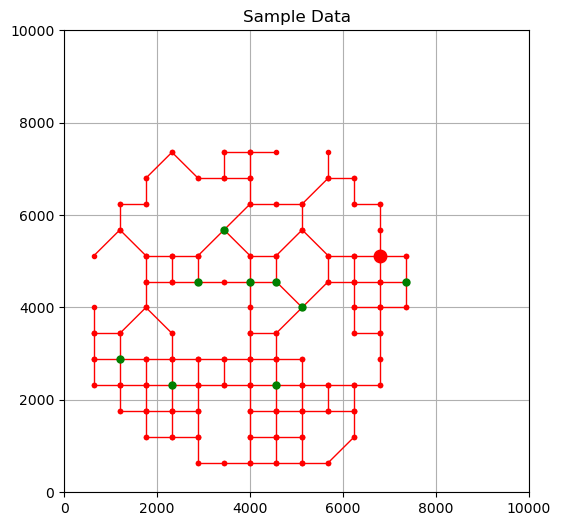

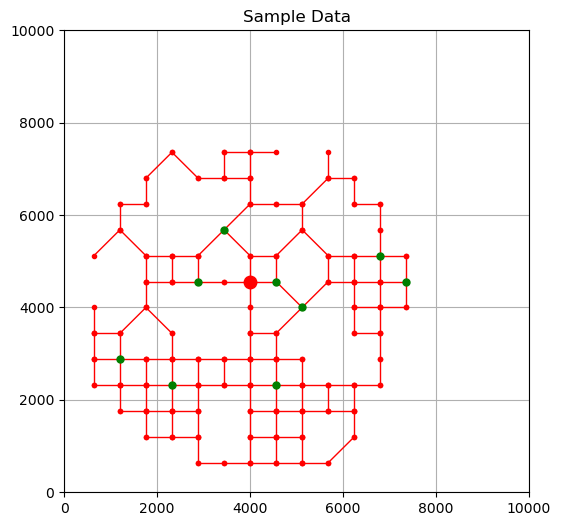

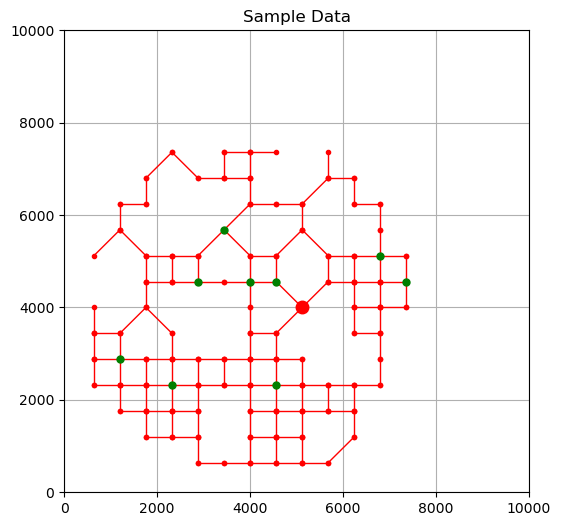

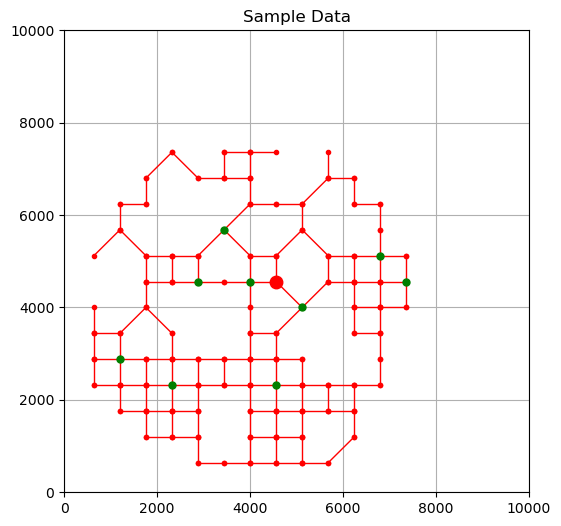

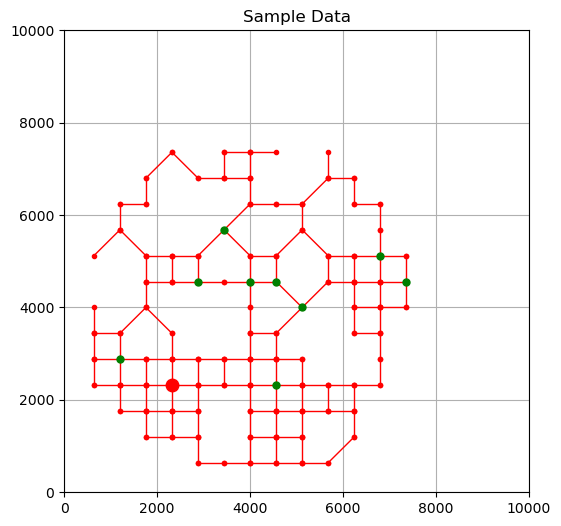

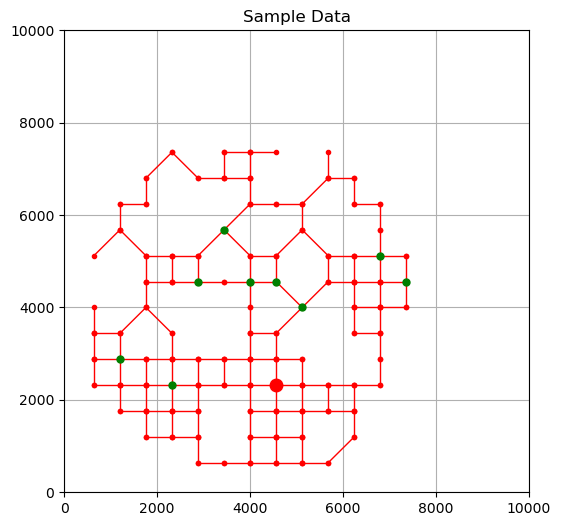

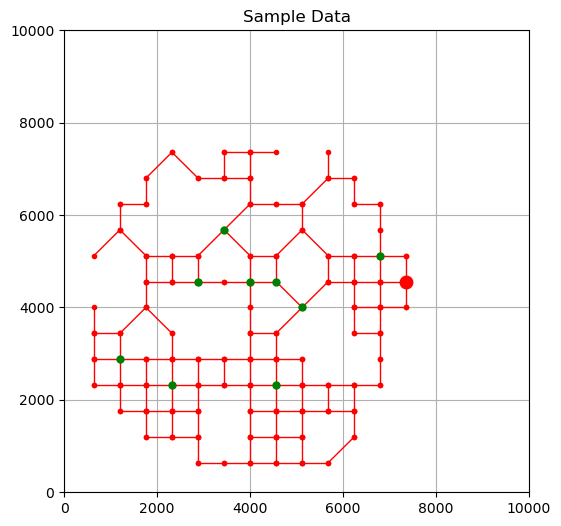

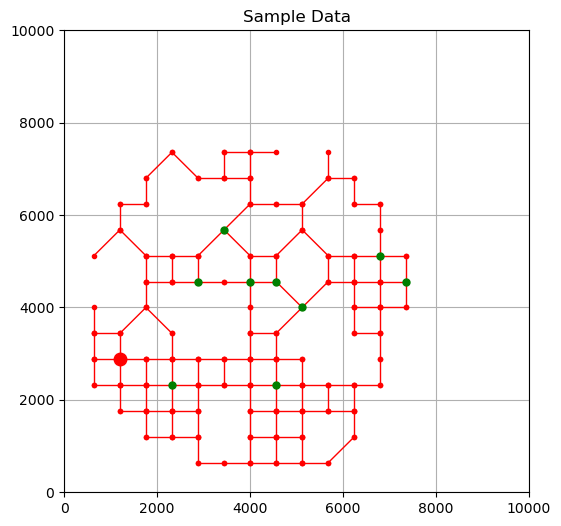

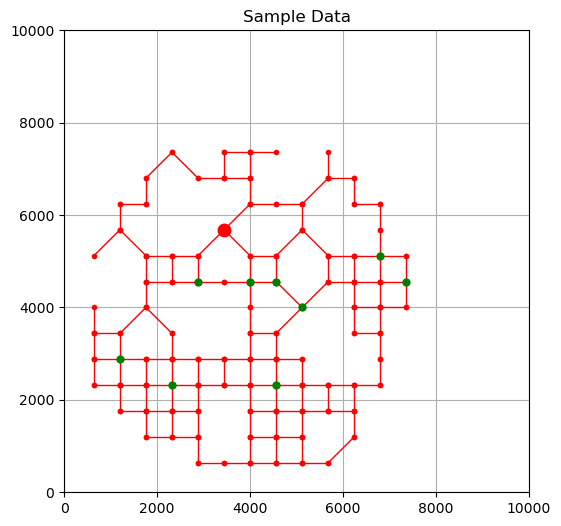

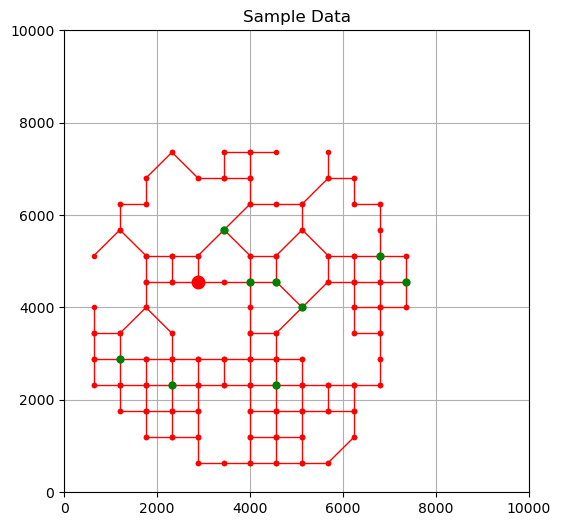

In [53]:
for w in W:
    plotMap(M, T=W, w=w, text='Sample Data', grid=True)

## Analysis

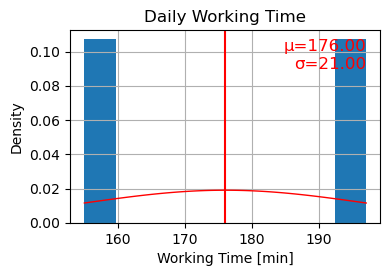

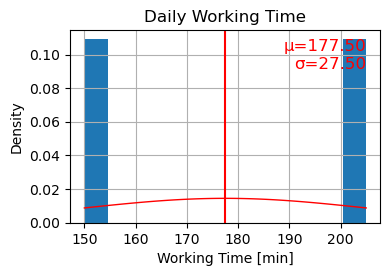

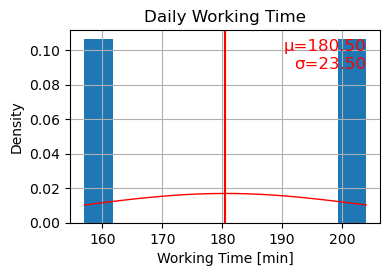

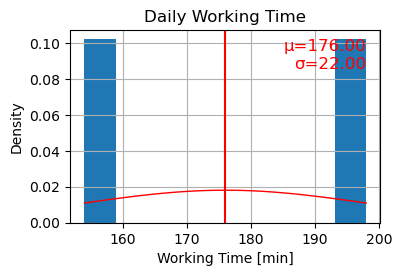

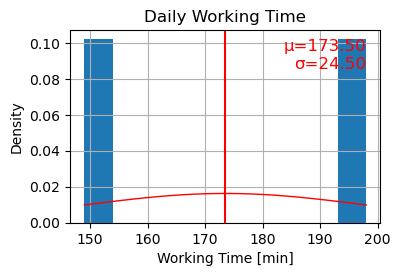

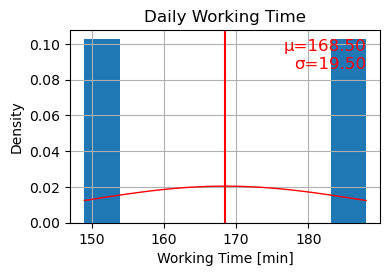

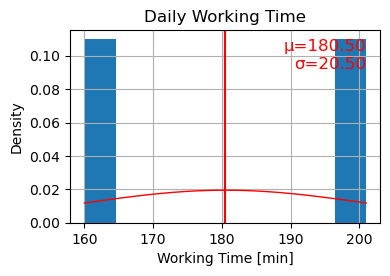

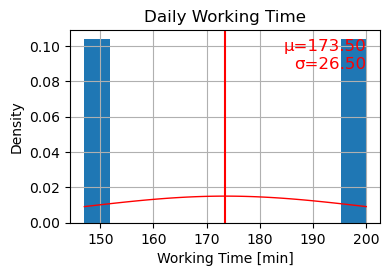

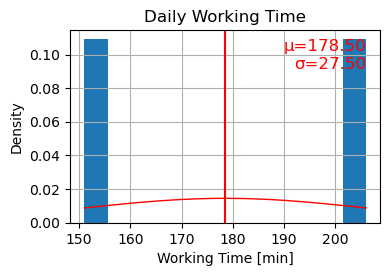

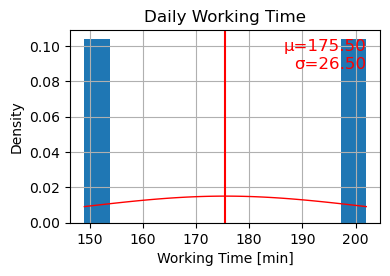

In [57]:
for rec in rec_diff_warehouses:
    rec.histWorkingTime()

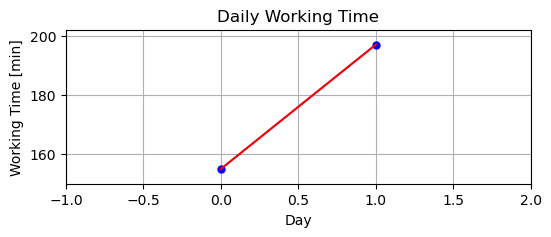

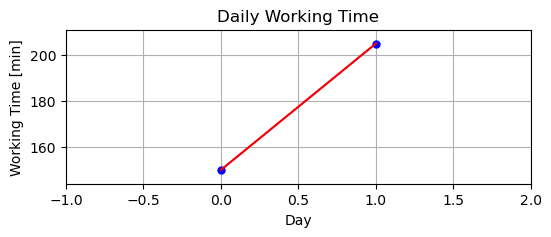

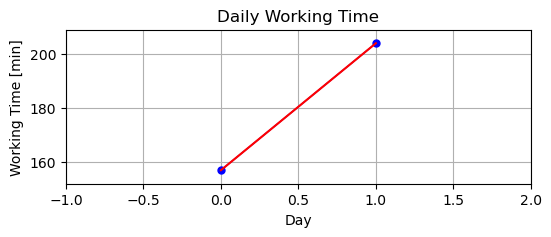

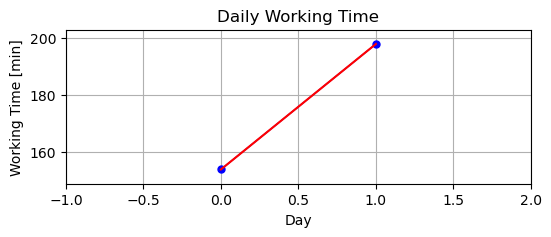

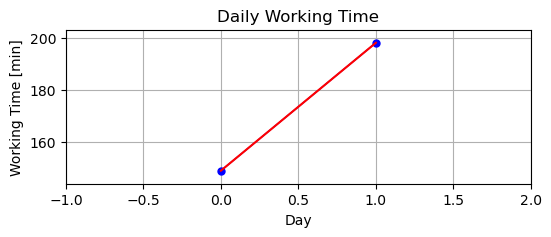

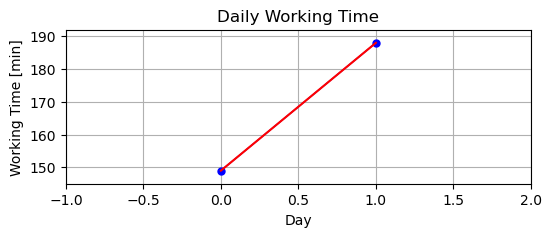

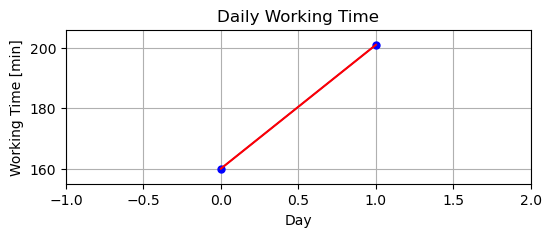

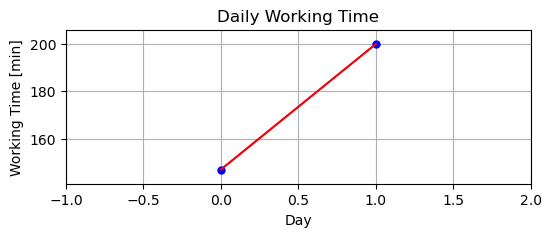

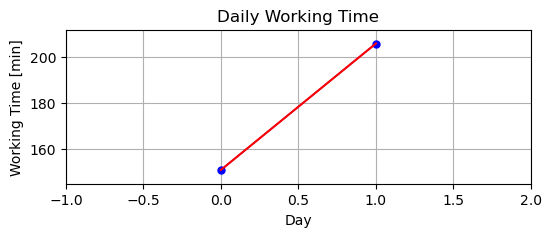

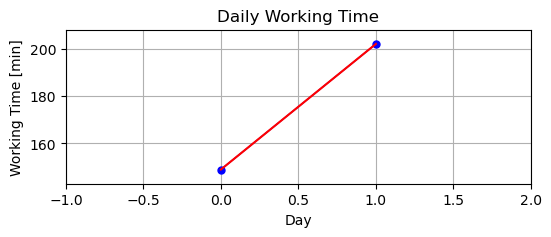

In [58]:
for rec in rec_diff_warehouses:
    rec.plotWorkingTime()

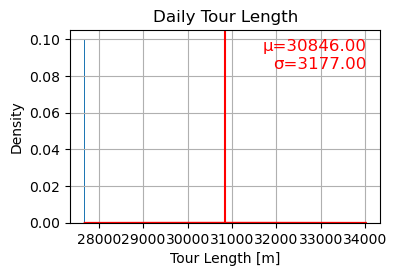

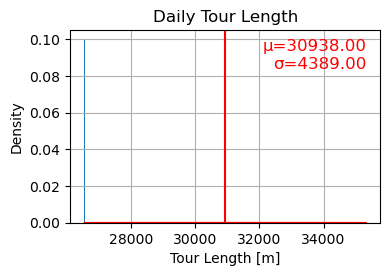

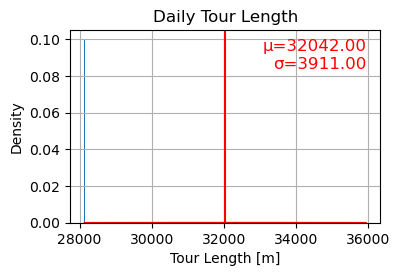

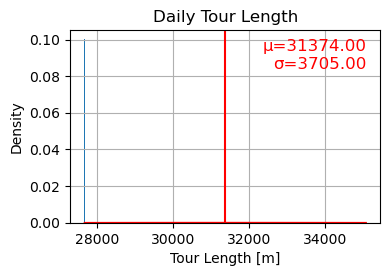

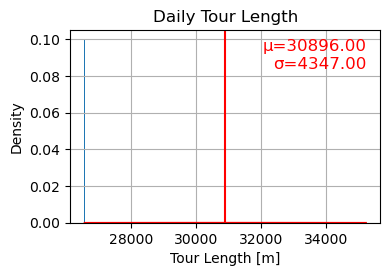

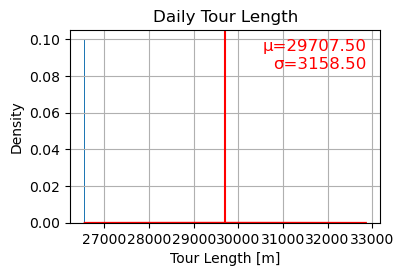

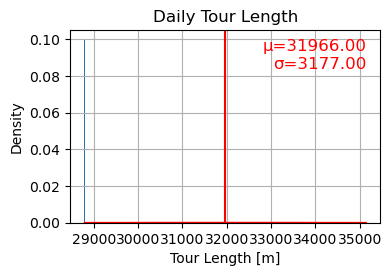

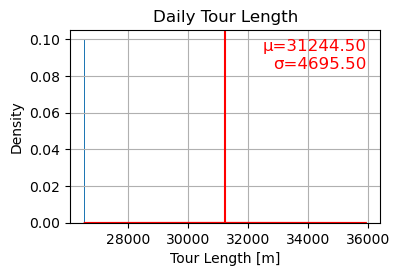

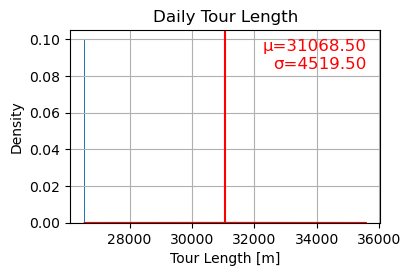

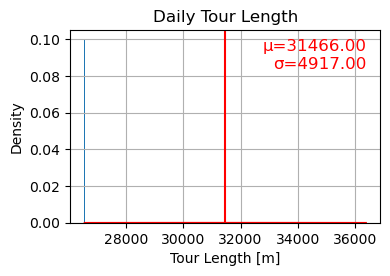

In [59]:
for rec in rec_diff_warehouses:
    rec.histTourLength()

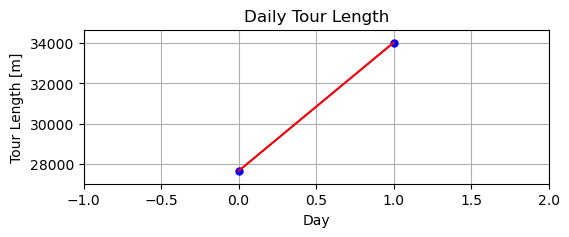

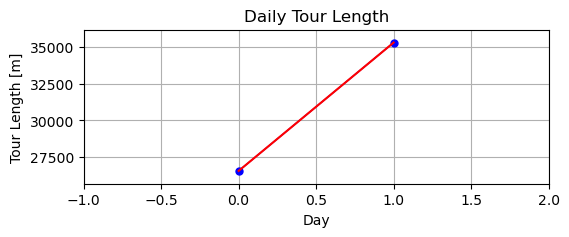

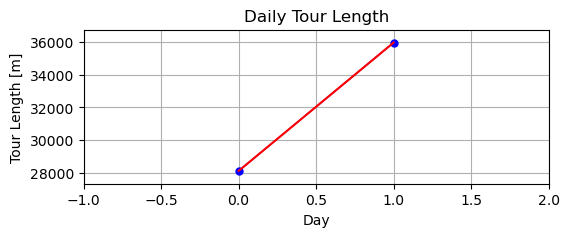

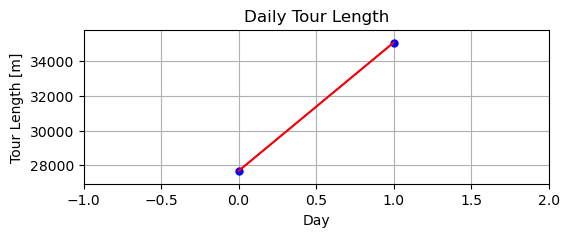

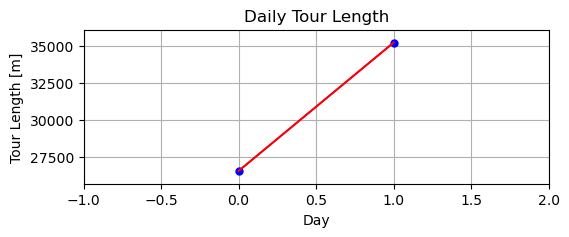

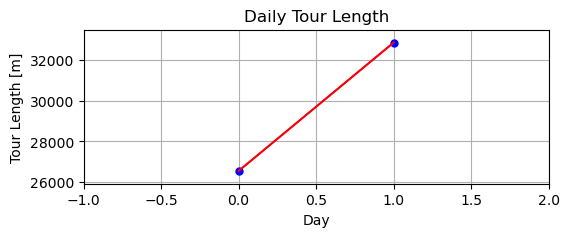

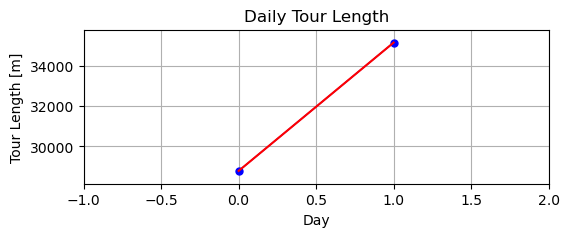

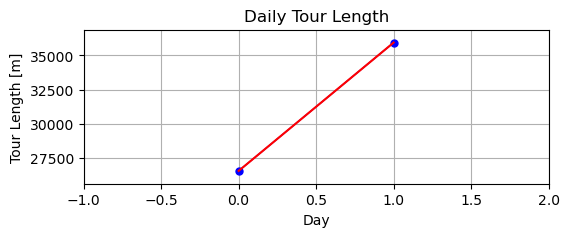

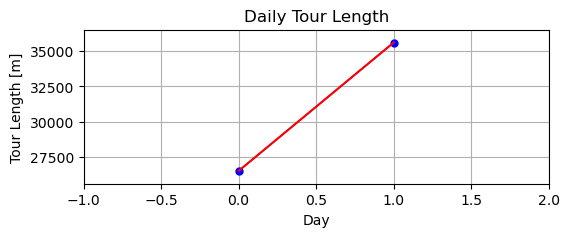

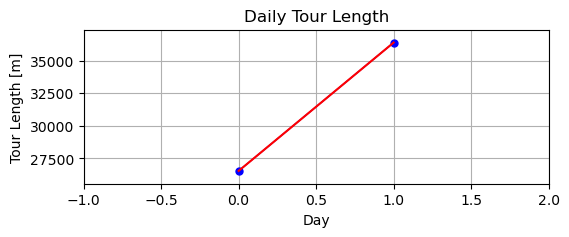

In [60]:
for rec in rec_diff_warehouses:
    rec.plotTourLength()

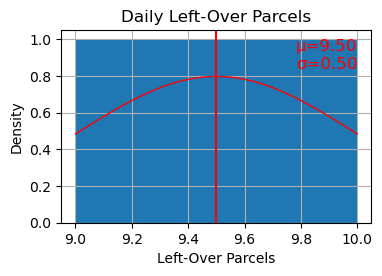

/opt/homebrew/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
posx and posy should be finite values
posx and posy should be finite values


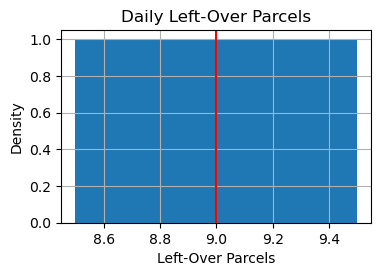

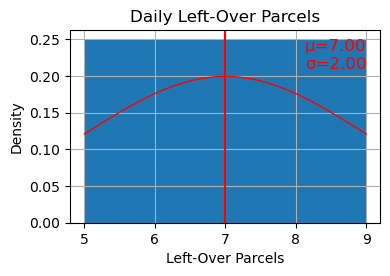

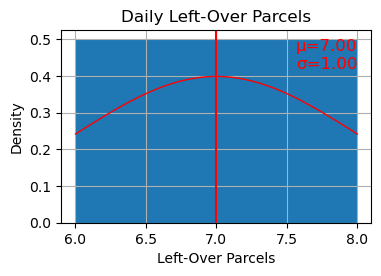

posx and posy should be finite values
posx and posy should be finite values


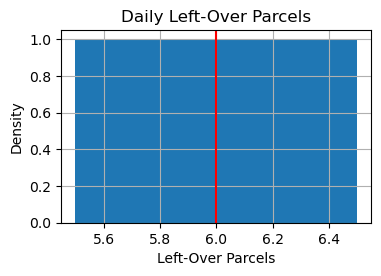

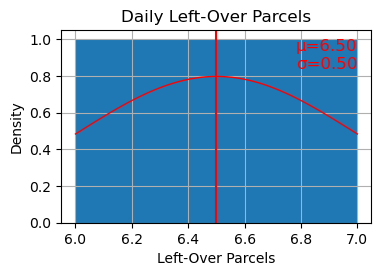

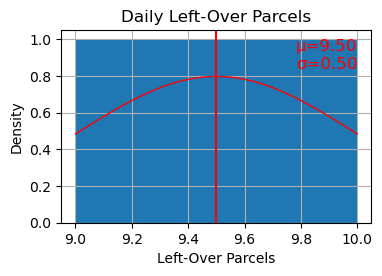

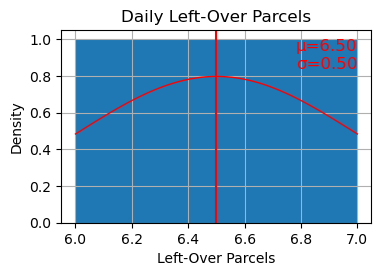

posx and posy should be finite values
posx and posy should be finite values


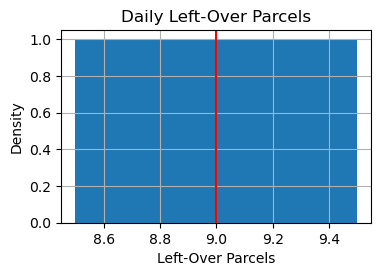

posx and posy should be finite values
posx and posy should be finite values


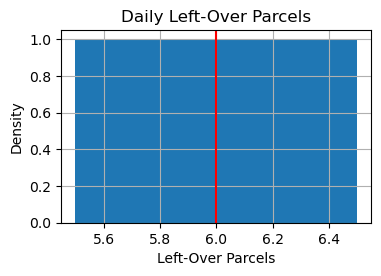

In [61]:
for rec in rec_diff_warehouses:
    rec.histLeftOver()

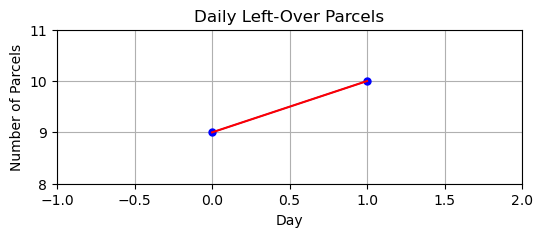

/var/folders/zx/xtb65vd10j9c6vn40s98w8hc0000gp/T/ipykernel_59046/678394850.py:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


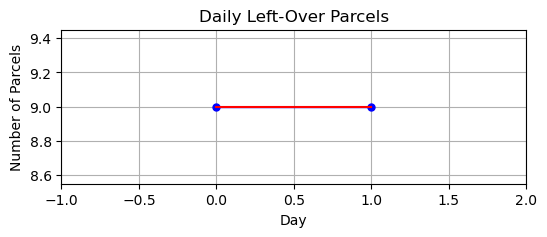

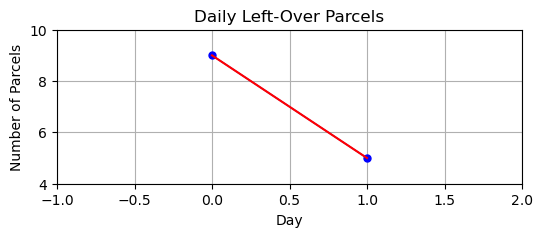

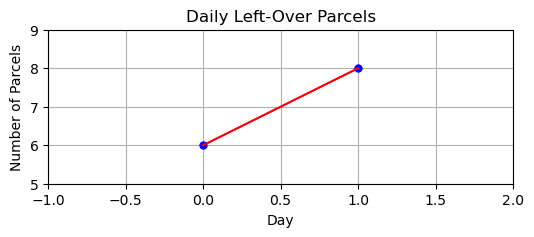

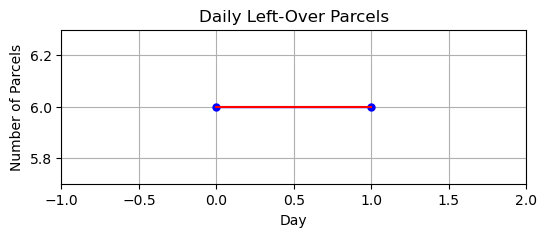

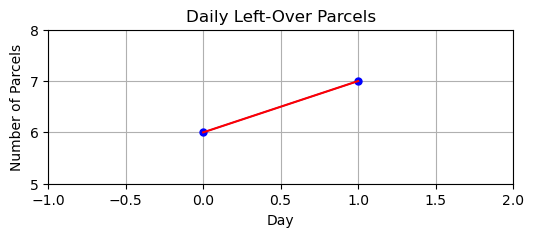

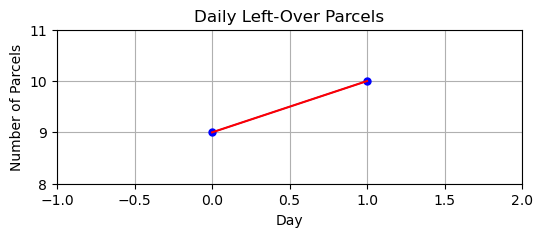

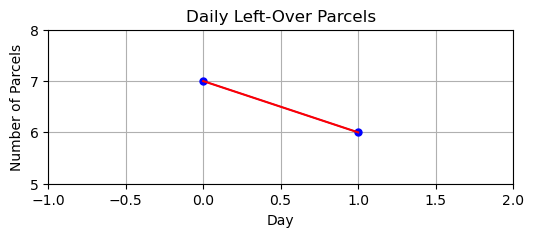

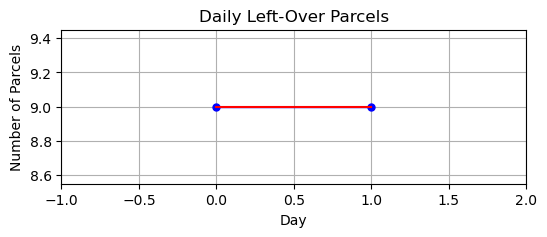

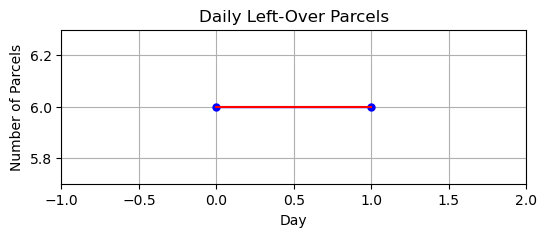

In [62]:
for rec in rec_diff_warehouses:
    rec.plotLeftOver()

In [63]:
for rec in rec_diff_warehouses:
    rec.tableParcelDelay()

Delivery Delay (40 parcels)
   None:     23   57.5%
 1 days:     15   37.5%
 2 days:      2    5.0%
Delivery Delay (40 parcels)
   None:     25   62.5%
 1 days:     12   30.0%
 2 days:      3    7.5%
Delivery Delay (40 parcels)
   None:     26   65.0%
 1 days:     14   35.0%
Delivery Delay (40 parcels)
   None:     30   75.0%
 1 days:     10   25.0%
Delivery Delay (40 parcels)
   None:     28   70.0%
 1 days:     12   30.0%
Delivery Delay (40 parcels)
   None:     32   80.0%
 1 days:      7   17.5%
 2 days:      1    2.5%
Delivery Delay (40 parcels)
   None:     23   57.5%
 1 days:     15   37.5%
 2 days:      2    5.0%
Delivery Delay (40 parcels)
   None:     29   72.5%
 1 days:     11   27.5%
Delivery Delay (40 parcels)
   None:     23   57.5%
 1 days:     16   40.0%
 2 days:      1    2.5%
Delivery Delay (40 parcels)
   None:     29   72.5%
 1 days:     10   25.0%
 2 days:      1    2.5%


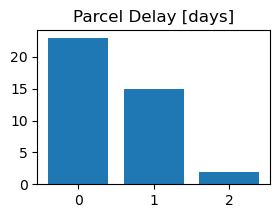

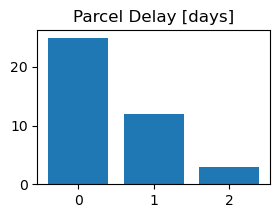

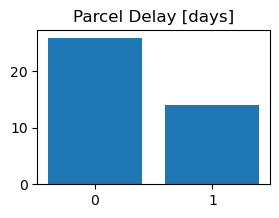

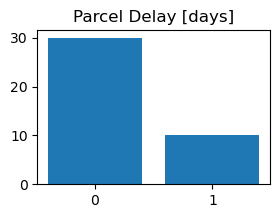

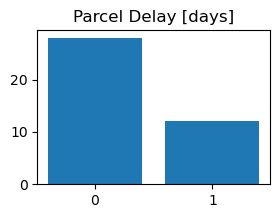

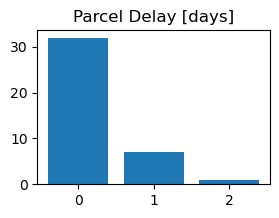

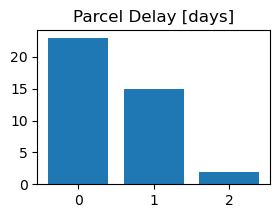

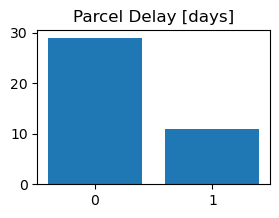

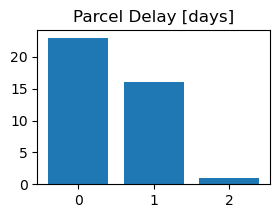

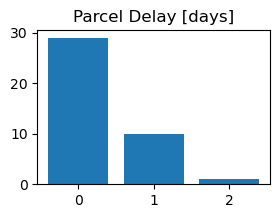

In [64]:
for rec in rec_diff_warehouses:
    rec.barplotParcelDelay()

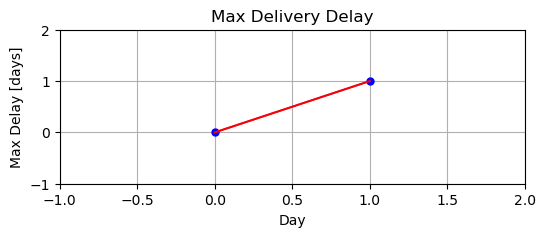

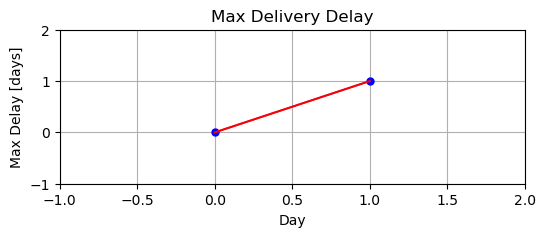

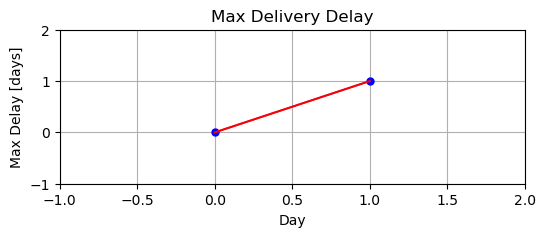

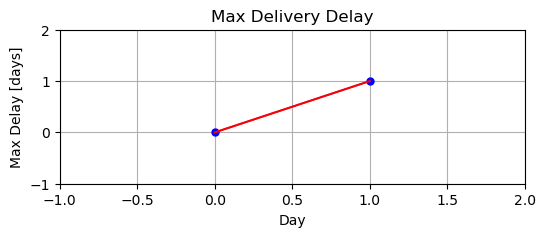

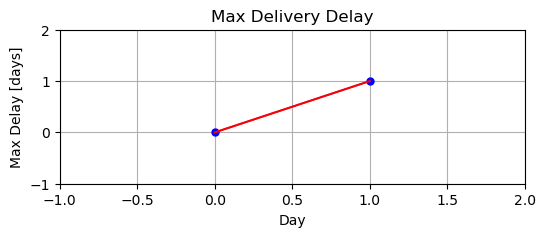

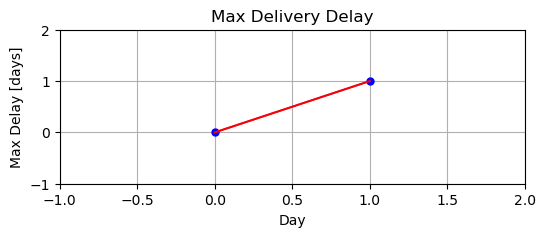

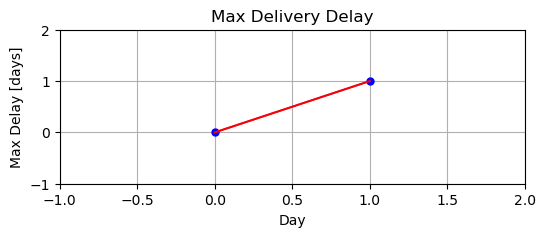

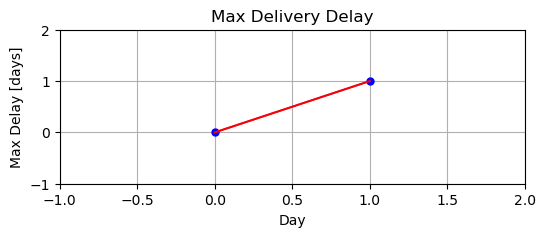

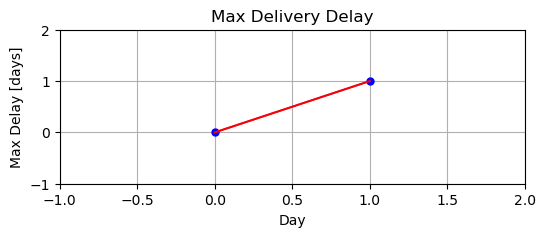

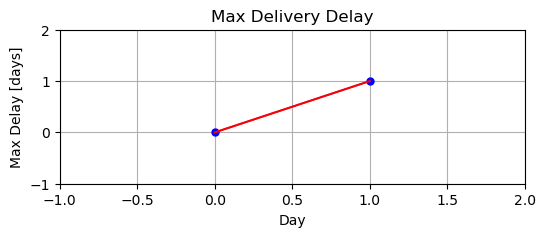

In [65]:
for rec in rec_diff_warehouses:
    rec.plotParcelDelay()

### Run small simulation heuristic

In [121]:
for w in W:
    print(formatLocation(w))

(6800,5120)
(4000,4560)
(5120,4000)
(4560,4560)
(2320,2320)
(4560,2320)
(7360,4560)
(1200,2880)
(3440,5680)
(2880,4560)


# MAIN CODE TO FIND BEST WAREHOUSE

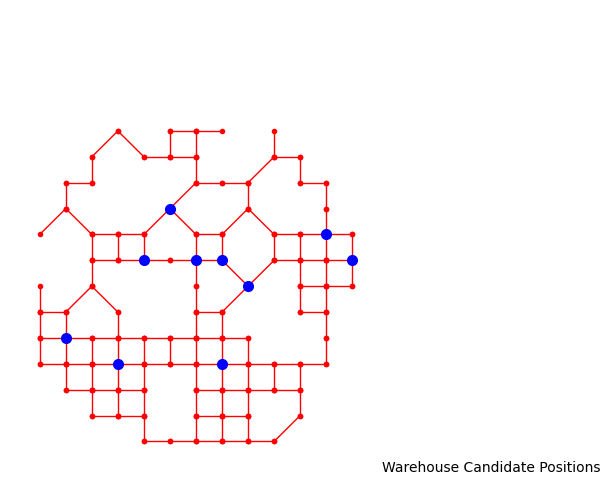

Simulate Delivery from Warehouse (6800,5120)
Simulating the delivery of 102 parcels over 5 days to 150 customers


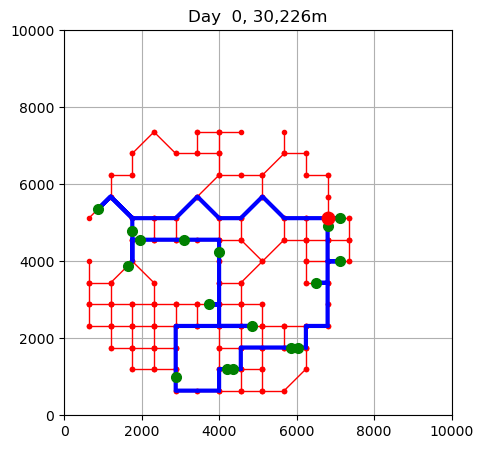

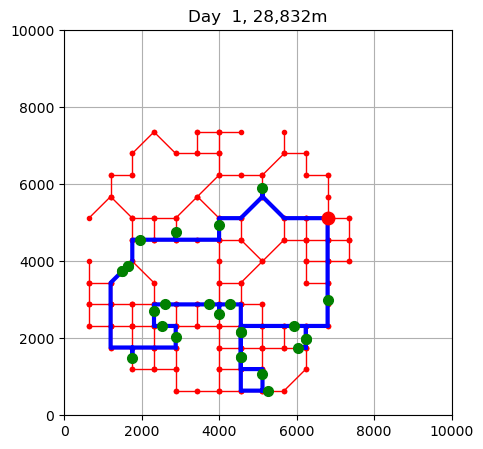

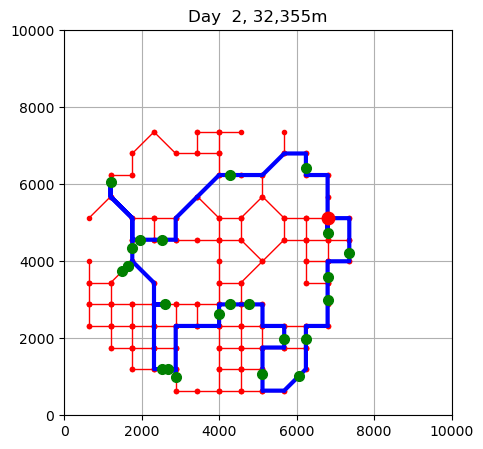

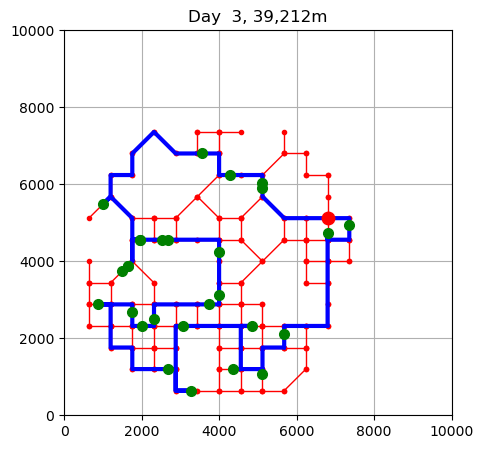

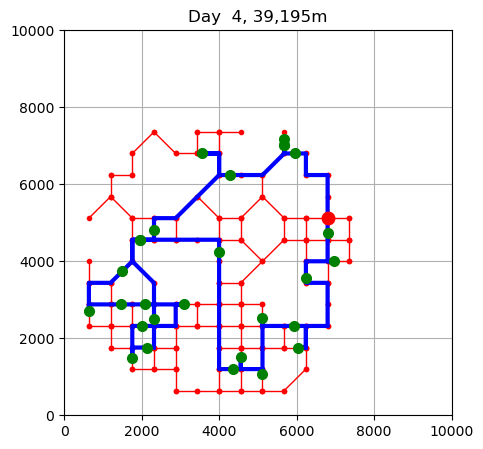

  improved position:   (6800,5120) cost= 100.15
Simulate Delivery from Warehouse (4000,4560)
Simulating the delivery of 102 parcels over 5 days to 150 customers


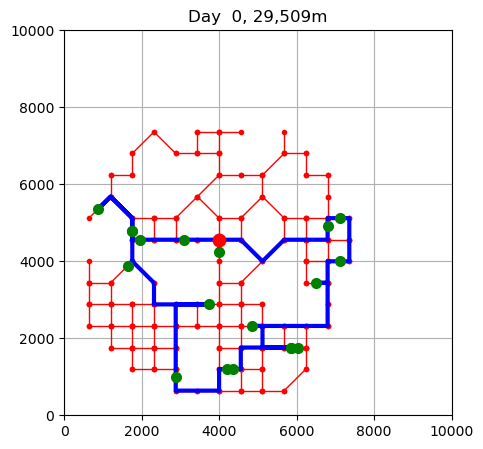

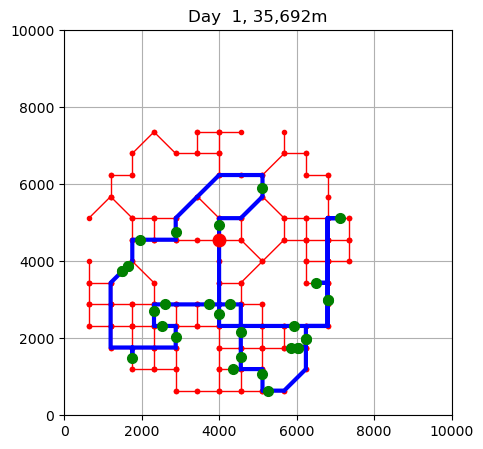

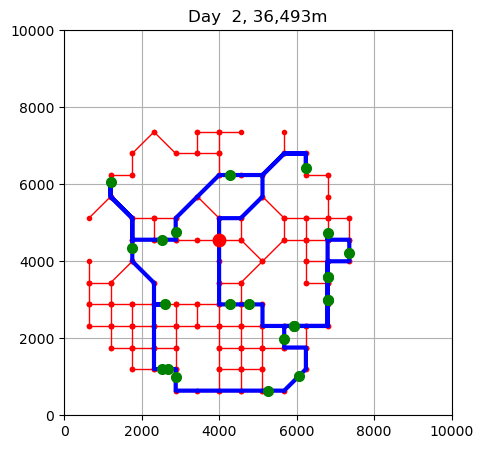

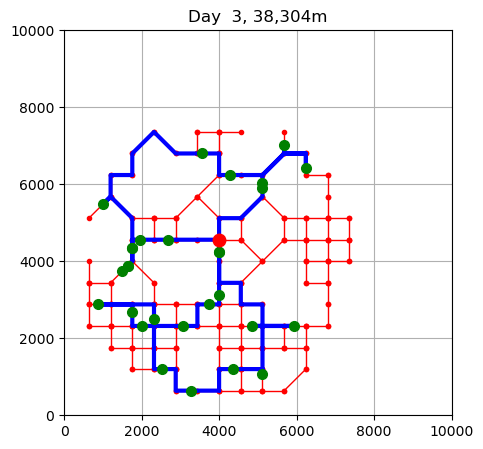

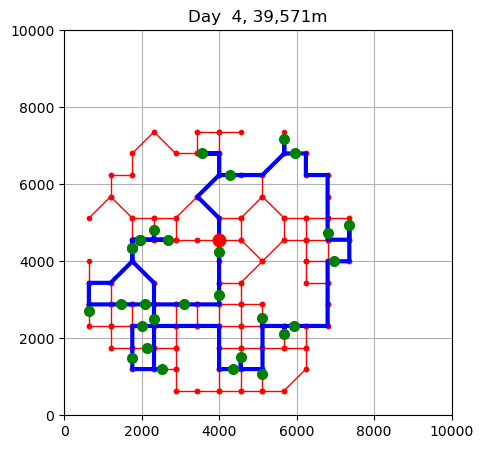

Simulate Delivery from Warehouse (5120,4000)
Simulating the delivery of 102 parcels over 5 days to 150 customers


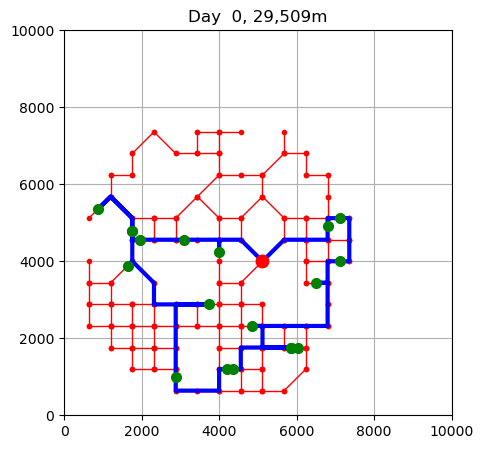

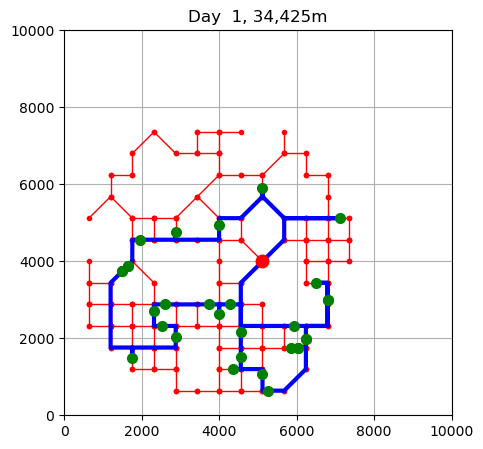

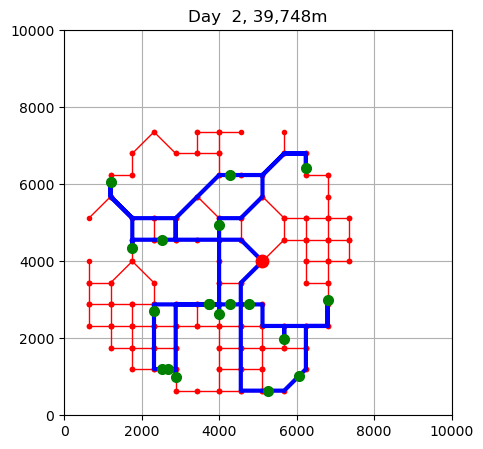

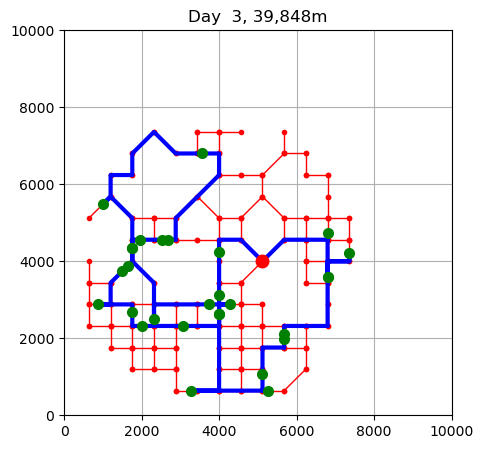

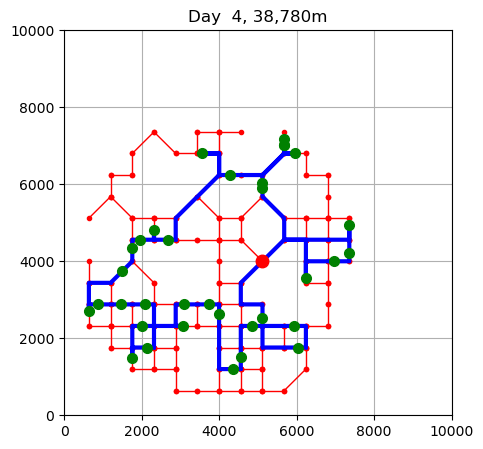

Simulate Delivery from Warehouse (4560,4560)
Simulating the delivery of 102 parcels over 5 days to 150 customers


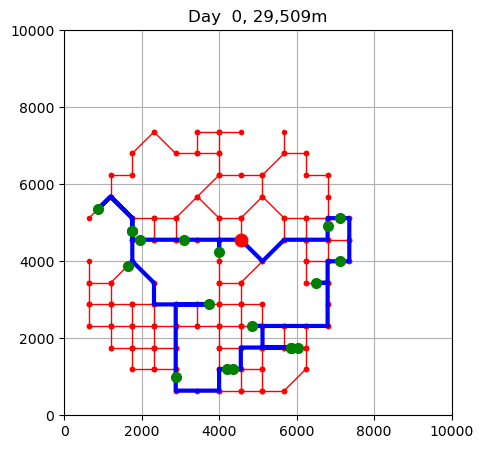

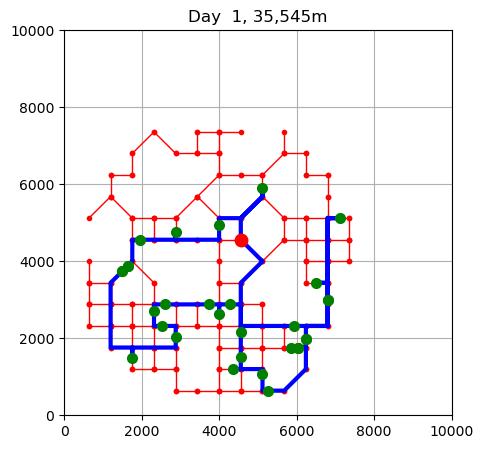

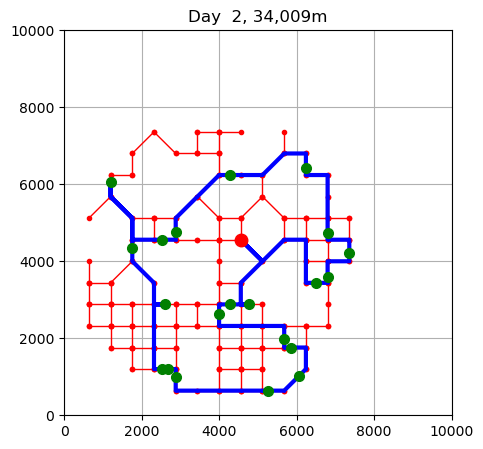

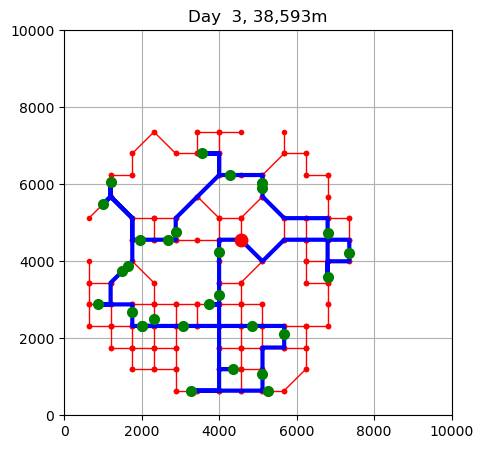

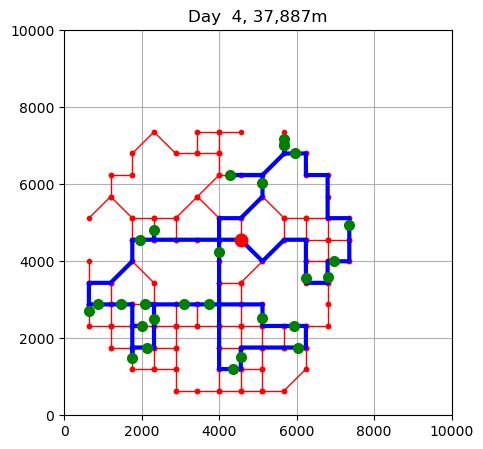

Simulate Delivery from Warehouse (2320,2320)
Simulating the delivery of 102 parcels over 5 days to 150 customers


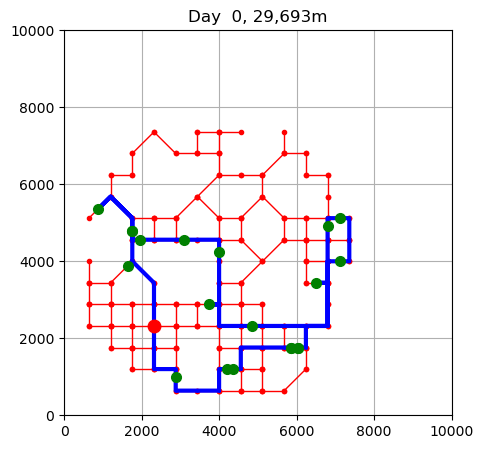

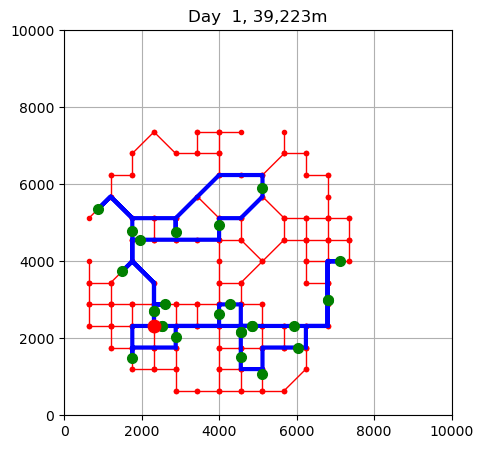

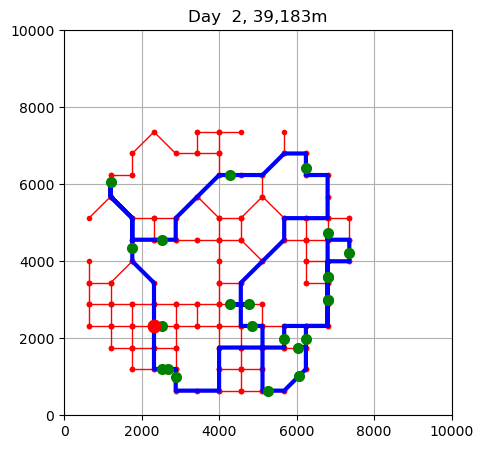

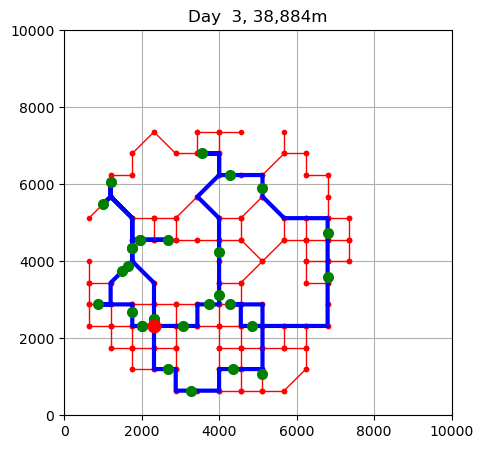

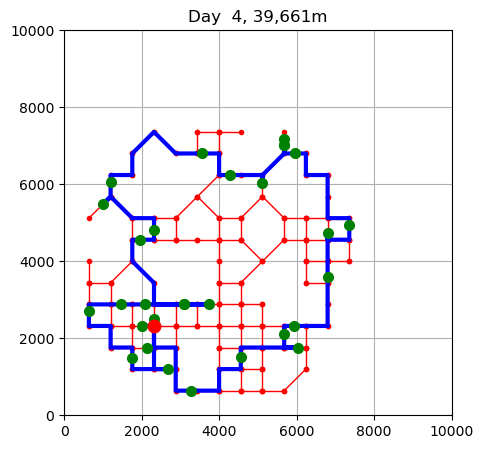

Simulate Delivery from Warehouse (4560,2320)
Simulating the delivery of 102 parcels over 5 days to 150 customers


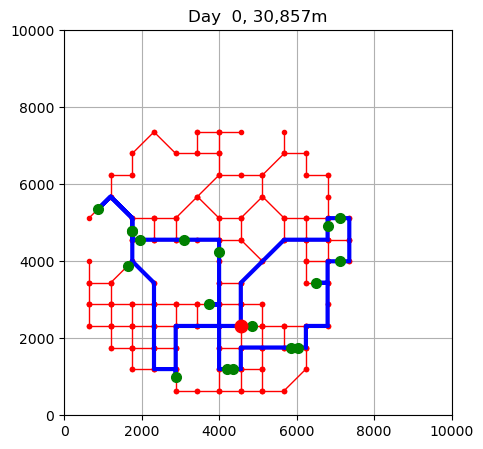

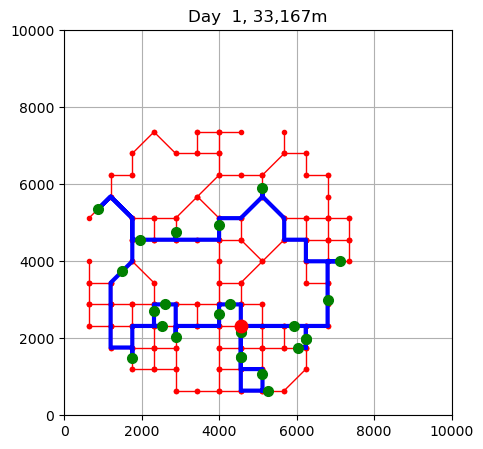

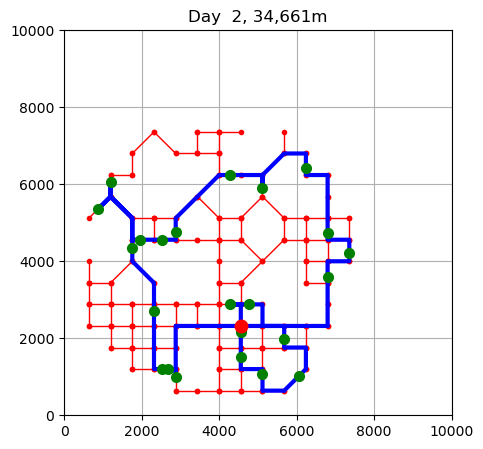

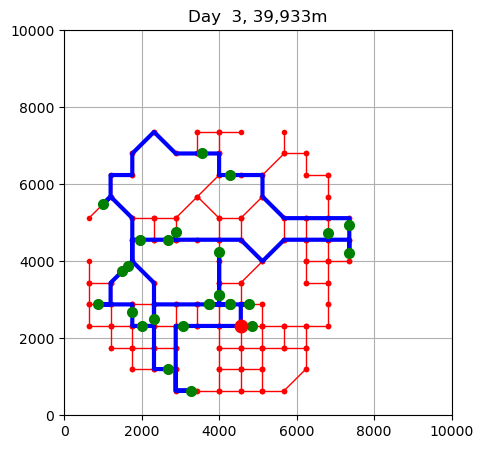

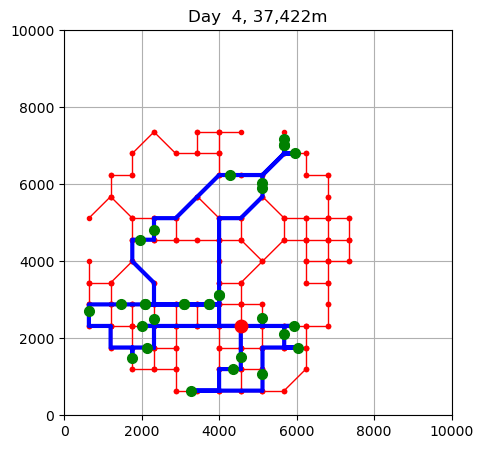

Simulate Delivery from Warehouse (7360,4560)
Simulating the delivery of 102 parcels over 5 days to 150 customers


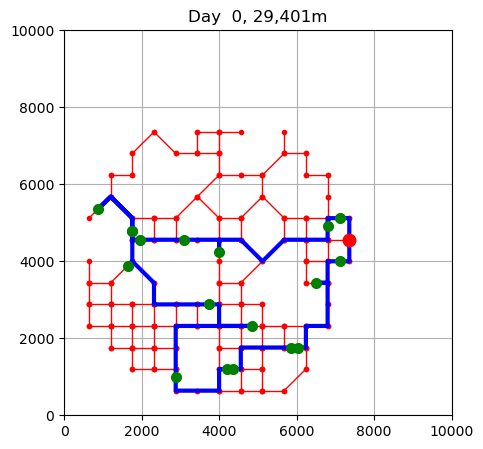

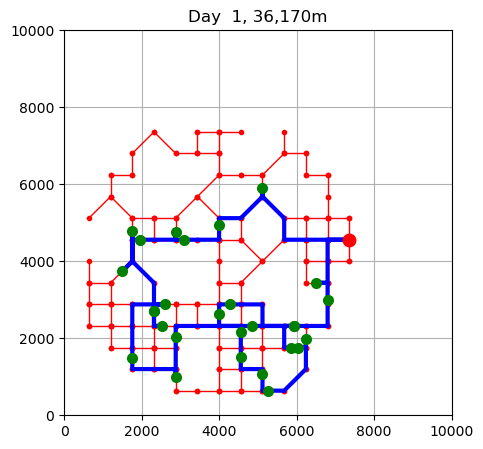

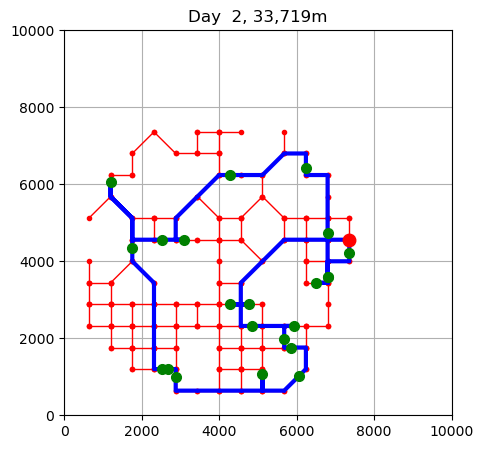

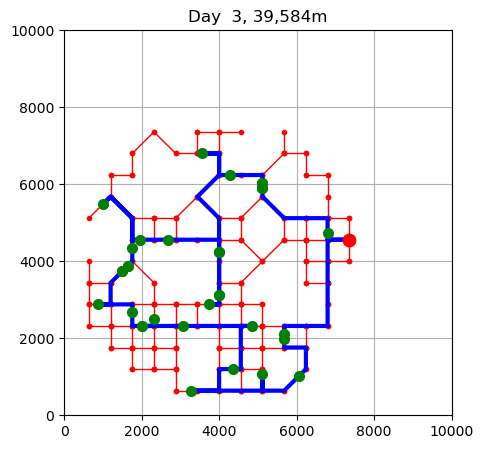

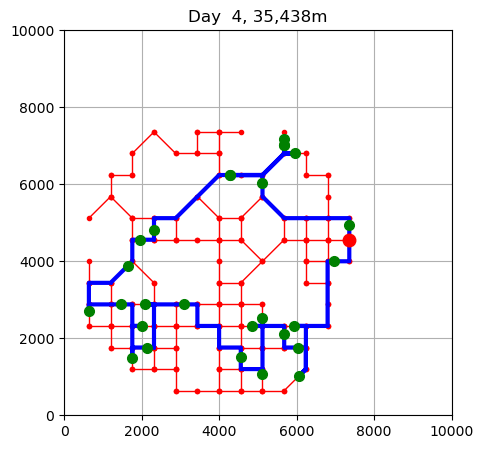

Simulate Delivery from Warehouse (1200,2880)
Simulating the delivery of 102 parcels over 5 days to 150 customers


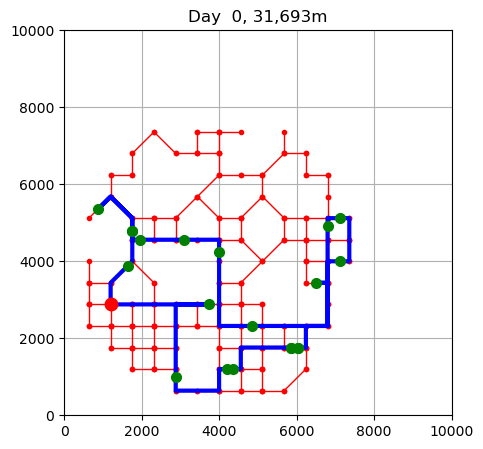

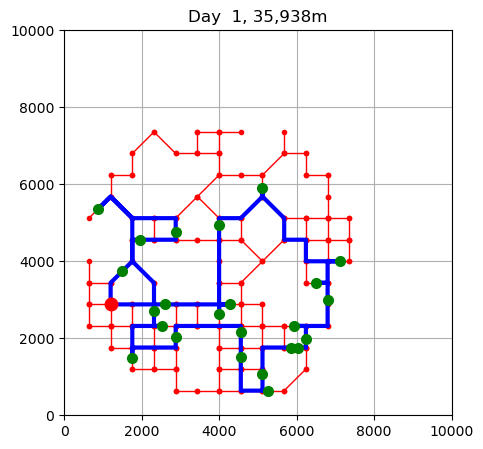

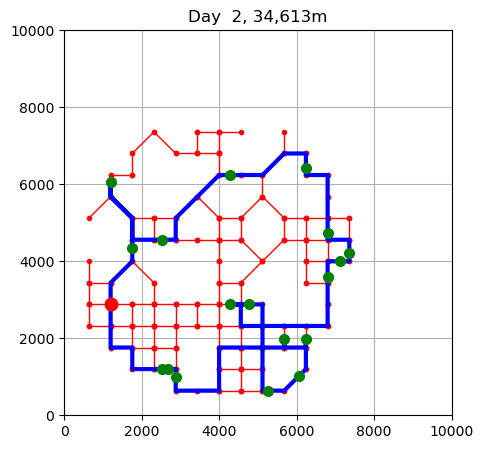

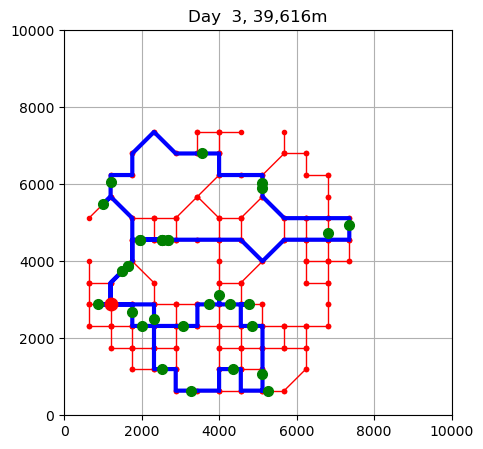

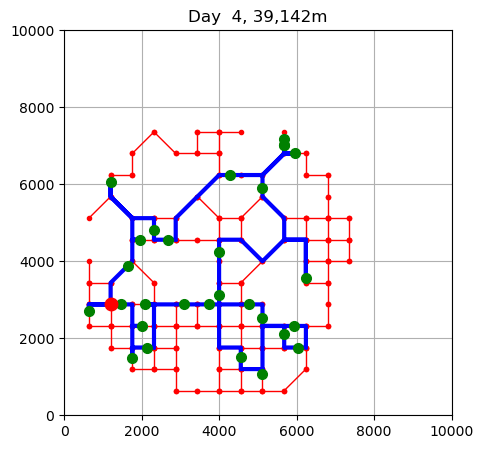

Simulate Delivery from Warehouse (3440,5680)
Simulating the delivery of 102 parcels over 5 days to 150 customers


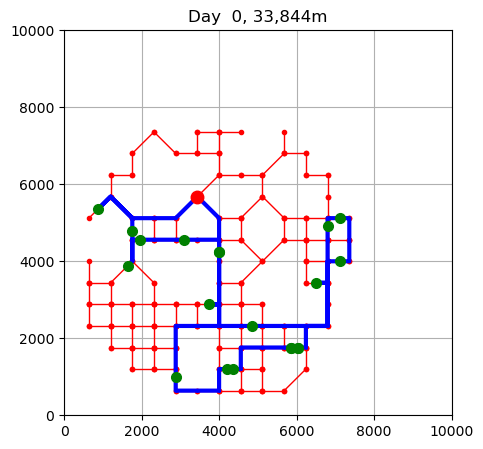

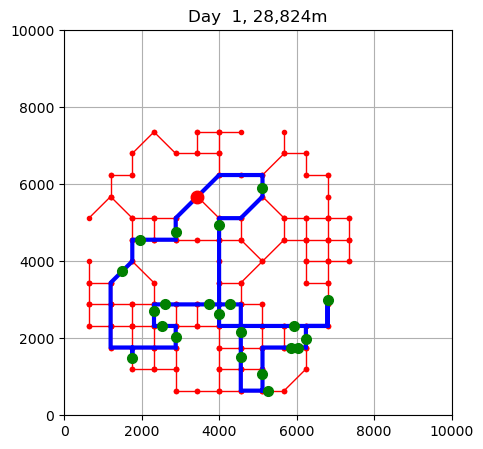

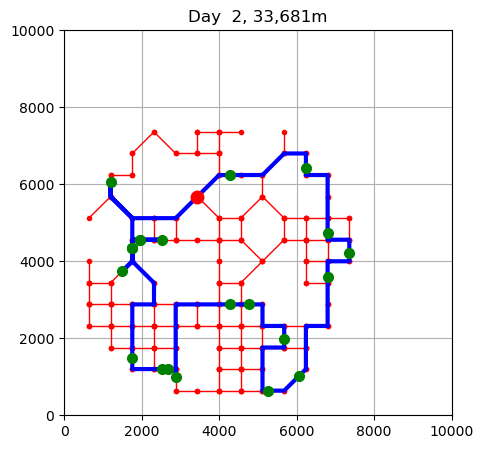

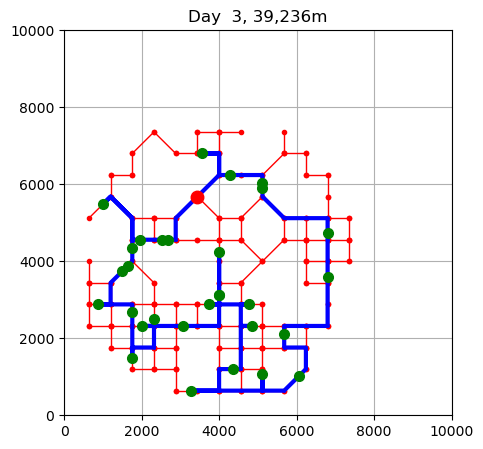

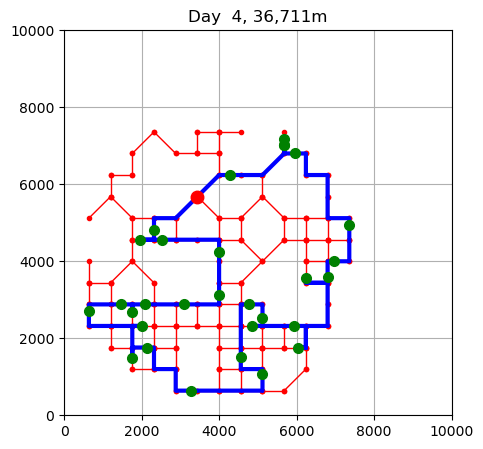

Simulate Delivery from Warehouse (2880,4560)
Simulating the delivery of 102 parcels over 5 days to 150 customers


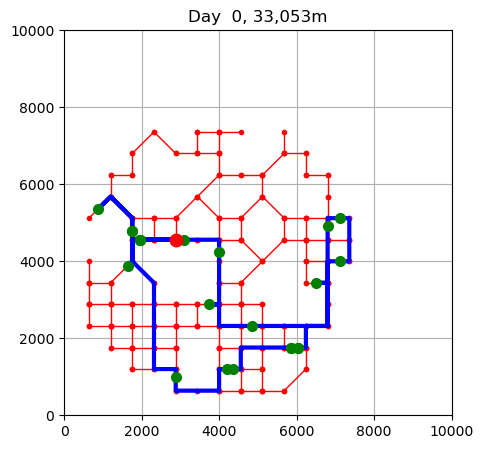

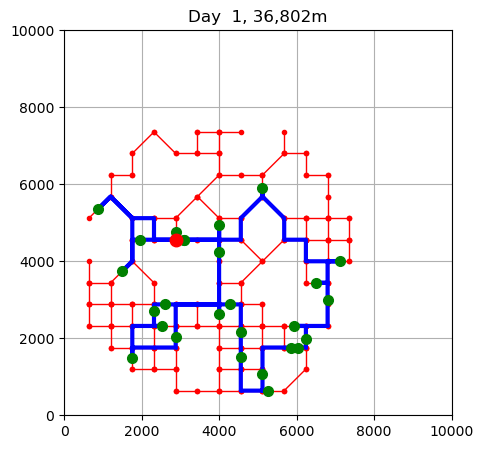

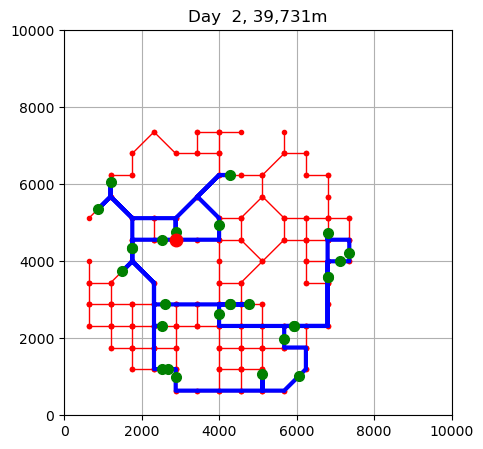

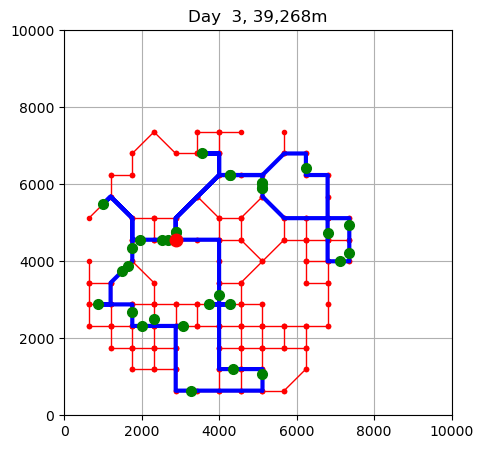

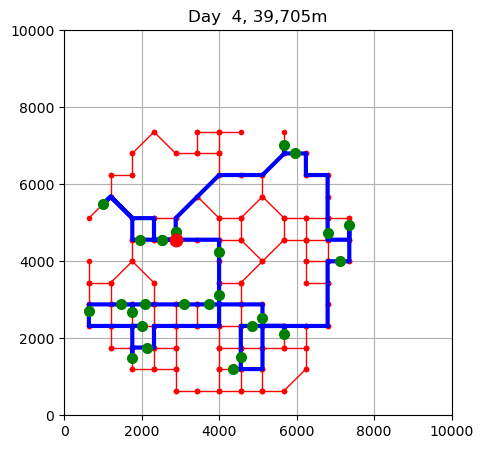

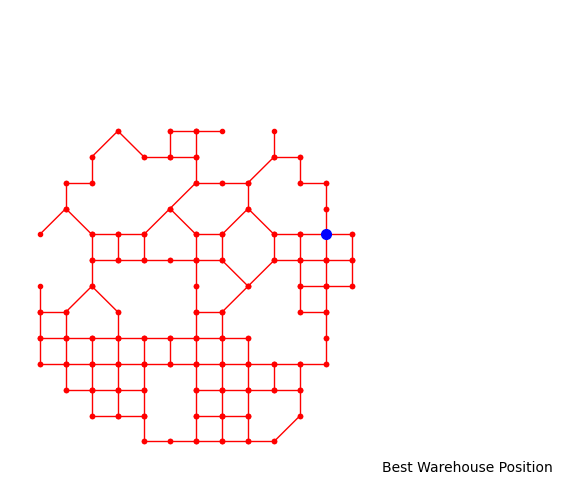

In [83]:
def formatLocation(w):
    return f"({w[0]:4d},{w[1]:4d})"

def monteCarlo(M,W,C,days,p,limit,seed,log=False,plot=False,heuristic=False):
    start=time.time()
    #plot candidate positions
    plotMap(M, T=W, styleT='bo', msT=7, 
            text="Warehouse Candidate Positions")
    
    #cost and save recorders
    minCost= float('inf')
    
    for w in W:
        title = "Simulate Delivery from Warehouse "+formatLocation(w)
        print(title)
        random.seed(seed)
        rec=simulation(M, w, C, days=days, p=0.15, limit=limit, log=log, plot=plot, heuristic=heuristic)
        
        #save simulations for hypothesis for all warehouses
        filename = "recorder/rec_w="+formatLocation(w)+".pickled"
        # Check if directory exists, if not, create it
        directory = os.path.dirname(filename)
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open(filename, 'wb') as f:
            pickle.dump(rec, f)
        
        # compare cost to find the best warehouse
        c=rec.daily.cost.mean()
        if c<minCost:
            minCost=c
            print(f"  improved position:   {formatLocation(w):s} cost={minCost:7.2f}")
            wBest=[w]
            recBest=[rec]
        elif c==minCost:
            print(f"  equivalent position: {formatLocation(w):s} cost={minCost:7.2f}")
            wBest.append(w)
            recBest.append(rec)
    #plot Best Warehouse
    plotMap(M, T=wBest, styleT='bo', msT=7, text="Best Warehouse Position")
    end=time.time()
        
    return recBest,wBest,minCost,end-start
        
recBest,wBest,minCost,simulationTime= monteCarlo(M,W,C,days=5,p=0.15,limit=40000,plot=True,heuristic=True,seed=seed)

In [81]:
print("Time for simulating best warehouse locations : "+str("%.2f"%(simulationTime/60))+" minutes")

Time for simulating best warehouse locations : 0.56 minutes


In [56]:
wBest

[(7360, 4560)]

In [58]:
recBest[0].daily.time.min()

9959

## Analysis

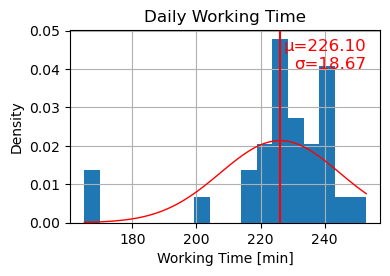

In [59]:
for rec in recBest:
    rec.histWorkingTime()

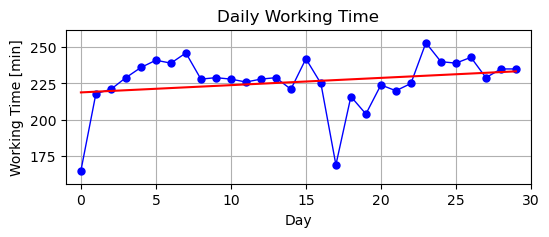

In [60]:
for rec in recBest:
    rec.plotWorkingTime()

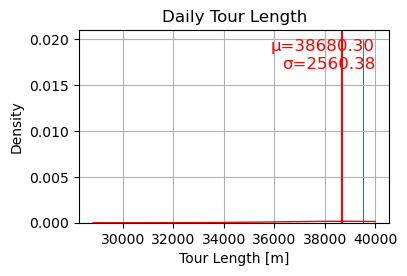

In [61]:
for rec in recBest:
    rec.histTourLength()

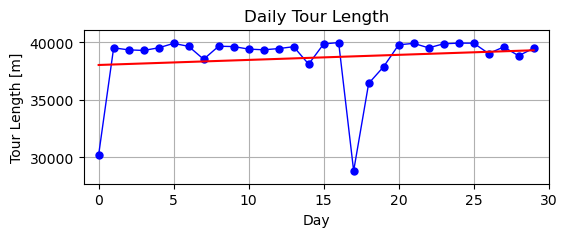

In [62]:
for rec in recBest:
    rec.plotTourLength()

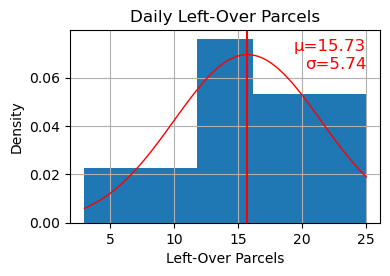

In [63]:
for rec in recBest:
    rec.histLeftOver()

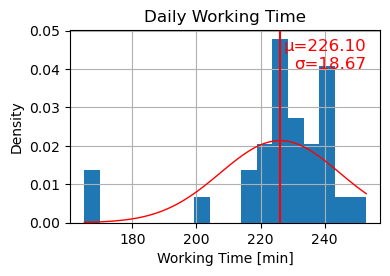

In [64]:
for rec in recBest:
    rec.histWorkingTime()

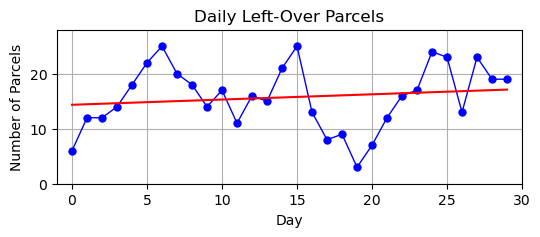

In [65]:
for rec in recBest:
    rec.plotLeftOver()

In [66]:
for rec in recBest:
    rec.tableParcelDelay()

Delivery Delay (713 parcels)
   None:    385   54.0%
 1 days:    241   33.8%
 2 days:     62    8.7%
 3 days:     18    2.5%
 4 days:      3    0.4%
 5 days:      4    0.6%


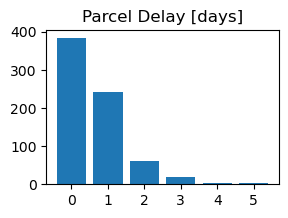

In [67]:
for rec in recBest:
    rec.barplotParcelDelay()

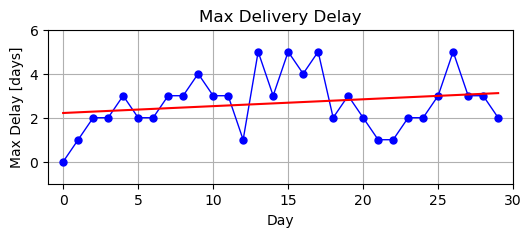

In [68]:
for rec in recBest:
    rec.plotParcelDelay()

### Ftest

We need to read all recorder files and then create a dataframe of cost related data for ANOVA

In [69]:
os.listdir('recorder')

['rec_w=(1200,2880).pickled',
 'rec_w=(2320,2320).pickled',
 'rec_w=(2880,4560).pickled',
 'rec_w=(3440,5680).pickled',
 'rec_w=(4000,4560).pickled',
 'rec_w=(4560,2320).pickled',
 'rec_w=(4560,4560).pickled',
 'rec_w=(5120,4000).pickled',
 'rec_w=(6800,5120).pickled',
 'rec_w=(7360,4560).pickled']

In [70]:
# Specify the folder containing pickle files
folder_path = 'recorder'

# Initialize an empty list to store the loaded data
loaded_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    #read all Data except for best Warehouse data
    for j in wBest:
        if formatLocation(j) not in filename:
            file_path = os.path.join(folder_path, filename)
            # Open the pickle file and load the data
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                loaded_data.append(data)
loaded_data

Null Hypothesis (H0): The mean cost of the chosen warehouse is not significantly different from the mean costs of other warehouses.
Alternative Hypothesis (H1): The mean cost of the chosen warehouse is significantly different from the mean costs of other warehouses.

In [72]:
import pandas as pd
from scipy.stats import f_oneway

# Assuming best_warehouse_cost is a series or list containing the costs of the best warehouse
best_warehouse_costs=[]
for rec in recBest:
    best_warehouse_costs.append(rec.daily.cost)

other_warehouse_costs=[]
for rec in loaded_data:
    other_warehouse_costs.append(rec.daily.cost)

# Perform F-test for each warehouse candidate
alpha = 0.05  # significance level
for i, candidate_costs in enumerate(best_warehouse_costs, start=1):
    f_statistic, p_value = f_oneway(candidate_costs, *other_warehouse_costs)
    print(p_value)
    # Interpret the results
    if p_value < alpha:
        print(f"Reject null hypothesis for warehouse candidate {i}. Variances are significantly different.")
    else:
        print(f"Fail to reject null hypothesis for warehouse candidate {i}. Variances are not significantly different.")


0.959566640727673
Fail to reject null hypothesis for warehouse candidate 1. Variances are not significantly different.
